In [1]:
import pandas as pd
from datetime import datetime
# CSV 파일 로드
identities_df = pd.read_csv('./csv/Identities.csv')
uptie_stats_df = pd.read_csv('./csv/Uptiestats.csv')
identities_skills_df = pd.read_csv('./csv/identities_skills_df.csv')
identities_skills_levels = pd.read_csv('./csv/Levelstats.csv')
level_stats_df = pd.read_csv('./csv/Levelstats.csv')

# 'Speed' 열을 '-'로 분할하여 평균 속도(MeanSpeed) 계산
uptie_stats_df[['MinSpeed', 'MaxSpeed']] = uptie_stats_df['Speed'].str.split('-', expand=True).astype(int)
uptie_stats_df['MeanSpeed'] = uptie_stats_df[['MinSpeed', 'MaxSpeed']].mean(axis=1)

# 필요 없는 열 제거
uptie_stats_df = uptie_stats_df.drop(columns=['Speed', 'MinSpeed', 'MaxSpeed'])

# Identity_ID별 평균 MeanSpeed 계산
identity_mean_speed = (
    uptie_stats_df.groupby("Identity_ID")["MeanSpeed"]
    .mean()
    .reset_index()
)

# 결과 확인
print(identity_mean_speed)

     Identity_ID  MeanSpeed
0          10101      5.625
1          10102      6.125
2          10103      4.625
3          10104      4.625
4          10105      5.125
..           ...        ...
121        11206      5.625
122        11207      4.625
123        11208      4.625
124        11209      5.125
125        11210      4.500

[126 rows x 2 columns]


In [4]:
calculate_standard_power_df = identities_skills_df.copy()

In [5]:
import re

# 숫자 추출 함수
def extract_number(value):
    match = re.match(r"(\d+)", value)  # 숫자만 추출
    return int(match.group(1)) if match else int(value)  # 숫자가 없으면 그대로 반환

# Init_Remain에서 숫자만 추출
calculate_standard_power_df["Init_Remain"] = calculate_standard_power_df["Init_Remain"].apply(extract_number)

# Init_Remain이 -1인 경우 1로 변경
calculate_standard_power_df["Init_Remain"] = calculate_standard_power_df["Init_Remain"].replace(-1, 1)

# AWAKE 접두사가 있는 행 확인
calculate_standard_power_df["Is_Awake"] = calculate_standard_power_df["Skill_Code"].str.startswith("AWAKE")

# `Mean_Power` 계산 함수
def calculate_mean_power(group):
    # Coin_Power가 음수이면 Coin_Count를 0으로 설정하여 영향 제거
    adjusted_coin_count = group["Coin_Count"].where(group["Coin_Power"] >= 0, 0)

    # 기본 Power 계산
    group["Power"] = (group["Skill_Power"] + adjusted_coin_count * group["Coin_Power"]) * group["Init_Remain"]
    
    # AWAKE인 경우 계산
    awake_power = group.loc[group["Is_Awake"], "Skill_Power"] + adjusted_coin_count[group["Is_Awake"]] * group.loc[group["Is_Awake"], "Coin_Power"]
    total_remain = group["Init_Remain"].sum() + group["Is_Awake"].sum()  # AWAKE가 있을 경우 total_remain에 +1
    
    mean_power = (group["Power"].sum() + awake_power.sum()) / total_remain if total_remain > 0 else 0
    return mean_power

# Grouping과 계산 (Identity_ID와 Uptie_Level 별로 Mean_Power 계산)
mean_power_results = (
    calculate_standard_power_df[calculate_standard_power_df["Init_Remain"] > 0]
    .groupby(["Identity_ID", "Uptie_Level"])
    .apply(calculate_mean_power)
    .reset_index(name="Mean_Power")
)

# ✅ Identity_ID 별로 Mean_Power 평균 계산
identity_mean_power = mean_power_results.groupby("Identity_ID")["Mean_Power"].mean().reset_index(name="Avg_Atk_Mean_Power")

# 결과 출력
print(identity_mean_power)


     Identity_ID  Avg_Atk_Mean_Power
0          10101           10.345238
1          10102           10.369048
2          10103           11.273810
3          10104           11.666667
4          10105           12.535714
..           ...                 ...
121        11206           12.107143
122        11207           12.392857
123        11208           11.678571
124        11209           12.666667
125        11210           13.535714

[126 rows x 2 columns]


/var/folders/27/r1qdd08x0fx8nvdhy823ntqw0000gn/T/ipykernel_13568/1157797730.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_mean_power)


In [6]:
import pandas as pd
import ast

# 데이터 로드
level_stats_df = pd.read_csv('./csv/LevelStats.csv')

# Skill_Levels 문자열을 리스트로 변환
level_stats_df["Skill_Levels"] = level_stats_df["Skill_Levels"].apply(ast.literal_eval)

# 스킬 레벨 평균 계산
def extract_mean_skill_level(skill_list):
    skill_levels = [int(s.split(": ")[1]) for s in skill_list if "SKILL" in s]
    return sum(skill_levels) / len(skill_levels) if skill_levels else 0

level_stats_df["Mean_Skill_Level"] = level_stats_df["Skill_Levels"].apply(extract_mean_skill_level)

# Identity_ID별 평균 값 계산
identity_mean_stats = (
    level_stats_df.groupby("Identity_ID")[["HP", "Defense", "Mean_Skill_Level"]]
    .mean()
    .reset_index()
    .rename(columns={"HP": "Mean_HP", "Defense": "Mean_Defense"})
)

# 결과 확인
print(identity_mean_stats)

     Identity_ID  Mean_HP  Mean_Defense  Mean_Skill_Level
0          10101   135.24         23.56         25.500000
1          10102   153.92         27.50         25.500000
2          10103   124.14         21.70         30.500000
3          10104   124.14         21.70         29.500000
4          10105   137.02         23.56         27.186667
..           ...      ...           ...               ...
121        11206   166.50         30.50         25.500000
122        11207   124.14         22.62         28.833333
123        11208   142.30         26.50         27.166667
124        11209   124.14         21.70         30.500000
125        11210   194.96         30.50         27.166667

[126 rows x 4 columns]


In [7]:
calculate_standard_power_df = identities_skills_df.copy()

In [8]:
open_date = datetime.strptime("2023-02-27", "%Y-%m-%d")
identities_df['Release_Date'] = pd.to_datetime(identities_df['Release_Date'], format='%Y-%m-%d')
identities_df["Open_Day_After_Release_Date"] = (identities_df["Release_Date"] - open_date).dt.days

In [9]:
import re

# 숫자 추출 함수
def extract_number(value):
    match = re.match(r"(\d+)", value)  # 숫자만 추출
    return int(match.group(1)) if match else int(value)  # 숫자가 없으면 그대로 반환

# Init_Remain에서 숫자만 추출
calculate_standard_power_df["Init_Remain"] = calculate_standard_power_df["Init_Remain"].apply(extract_number)

# Init_Remain이 -1인 경우 1로 변경
calculate_standard_power_df["Init_Remain"] = calculate_standard_power_df["Init_Remain"].replace(-1, 1)

# AWAKE 접두사가 있는 행 확인
calculate_standard_power_df["Is_Awake"] = calculate_standard_power_df["Skill_Code"].str.startswith("AWAKE")

# `defense` 관련 스킬의 평균을 계산하는 함수
def calculate_defense_mean_power(group):
    # 'defense'가 포함된 스킬 코드만 필터링
    defense_group = group[group["Skill_Code"].str.contains("defense", case=False, na=False)]
    
    # Coin_Power가 음수이면 Coin_Count를 0으로 설정하여 영향 제거
    adjusted_coin_count = defense_group["Coin_Count"].where(defense_group["Coin_Power"] >= 0, 0)

    # 기본 Power 계산
    defense_group["Power"] = (defense_group["Skill_Power"] + adjusted_coin_count * defense_group["Coin_Power"]) * defense_group["Init_Remain"]
    
    # AWAKE인 경우 계산
    awake_power = defense_group.loc[defense_group["Is_Awake"], "Skill_Power"] + adjusted_coin_count[defense_group["Is_Awake"]] * defense_group.loc[defense_group["Is_Awake"], "Coin_Power"]
    total_remain = defense_group["Init_Remain"].sum() + defense_group["Is_Awake"].sum()  # AWAKE가 있을 경우 total_remain에 +1
    
    mean_power = (defense_group["Power"].sum() + awake_power.sum()) / total_remain if total_remain > 0 else 0
    return mean_power

# Grouping과 계산 (Identity_ID와 Uptie_Level 별로 defense 스킬의 Mean_Power 계산)
defense_mean_power_results = (
    calculate_standard_power_df[calculate_standard_power_df["Init_Remain"] > 0]
    .groupby(["Identity_ID", "Uptie_Level"])
    .apply(calculate_defense_mean_power)
    .reset_index(name="Defense_Mean_Power")
)

# ✅ Identity_ID 별로 defense 스킬의 Mean_Power 평균 계산
identity_defense_mean_power = defense_mean_power_results.groupby("Identity_ID")["Defense_Mean_Power"].mean().reset_index(name="Avg_Def_Mean_Power")

# 결과 출력
print(identity_defense_mean_power)


     Identity_ID  Avg_Def_Mean_Power
0          10101               10.00
1          10102               12.00
2          10103               16.50
3          10104               14.00
4          10105               12.75
..           ...                 ...
121        11206               17.75
122        11207               14.00
123        11208               13.75
124        11209               13.25
125        11210               20.00

[126 rows x 2 columns]


/var/folders/27/r1qdd08x0fx8nvdhy823ntqw0000gn/T/ipykernel_13568/1978580287.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_defense_mean_power)


In [10]:
identities_release_date_df = identities_df.rename(columns={"ID": "Identity_ID"})[["Identity_ID","Open_Day_After_Release_Date"]]


In [11]:
identities_release_date_df

Identity_ID  Open_Day_After_Release_Date
0          10101                            0
1          10102                            0
2          10103                            0
3          10104                          108
4          10105                          199
..           ...                          ...
121        11206                          164
122        11207                          262
123        11208                          360
124        11209                          402
125        11210                          612

[126 rows x 2 columns]

In [12]:
topic_modeling_df = pd.read_csv("./identities_summary/topic_modeling_t5_clustered_identity.csv")

In [13]:
topic_modeling_df = topic_modeling_df.rename(columns={"T5_Topic_Number": "Topic_Number"})[["Identity_ID", "Topic_Number"]]


In [14]:
topic_modeling_df

Identity_ID  Topic_Number
0          10101             7
1          10102             1
2          10103             3
3          10104             7
4          10105             1
..           ...           ...
121        11206             2
122        11207             3
123        11208             0
124        11209             8
125        11210             0

[126 rows x 2 columns]

In [15]:
import pandas as pd

# 병합 순서: 왼쪽부터 순차적으로 Identity_ID 기준으로 병합
merged_df = (topic_modeling_df
    .merge(identities_release_date_df, on="Identity_ID", how="left")
    .merge(identity_mean_stats, on="Identity_ID", how="left")
    .merge(identity_mean_power, on="Identity_ID", how="left")
    .merge(identity_defense_mean_power, on="Identity_ID", how="left")
    .merge(identity_mean_speed, on="Identity_ID", how="left")
)

# 결과 확인
print(merged_df.head())
drop_identity_id_df = merged_df.drop(columns=["Identity_ID"])

   Identity_ID  Topic_Number  Open_Day_After_Release_Date  Mean_HP  \
0        10101             7                            0   135.24   
1        10102             1                            0   153.92   
2        10103             3                            0   124.14   
3        10104             7                          108   124.14   
4        10105             1                          199   137.02   

   Mean_Defense  Mean_Skill_Level  Avg_Atk_Mean_Power  Avg_Def_Mean_Power  \
0         23.56         25.500000           10.345238               10.00   
1         27.50         25.500000           10.369048               12.00   
2         21.70         30.500000           11.273810               16.50   
3         21.70         29.500000           11.666667               14.00   
4         23.56         27.186667           12.535714               12.75   

   MeanSpeed  
0      5.625  
1      6.125  
2      4.625  
3      4.625  
4      5.125  


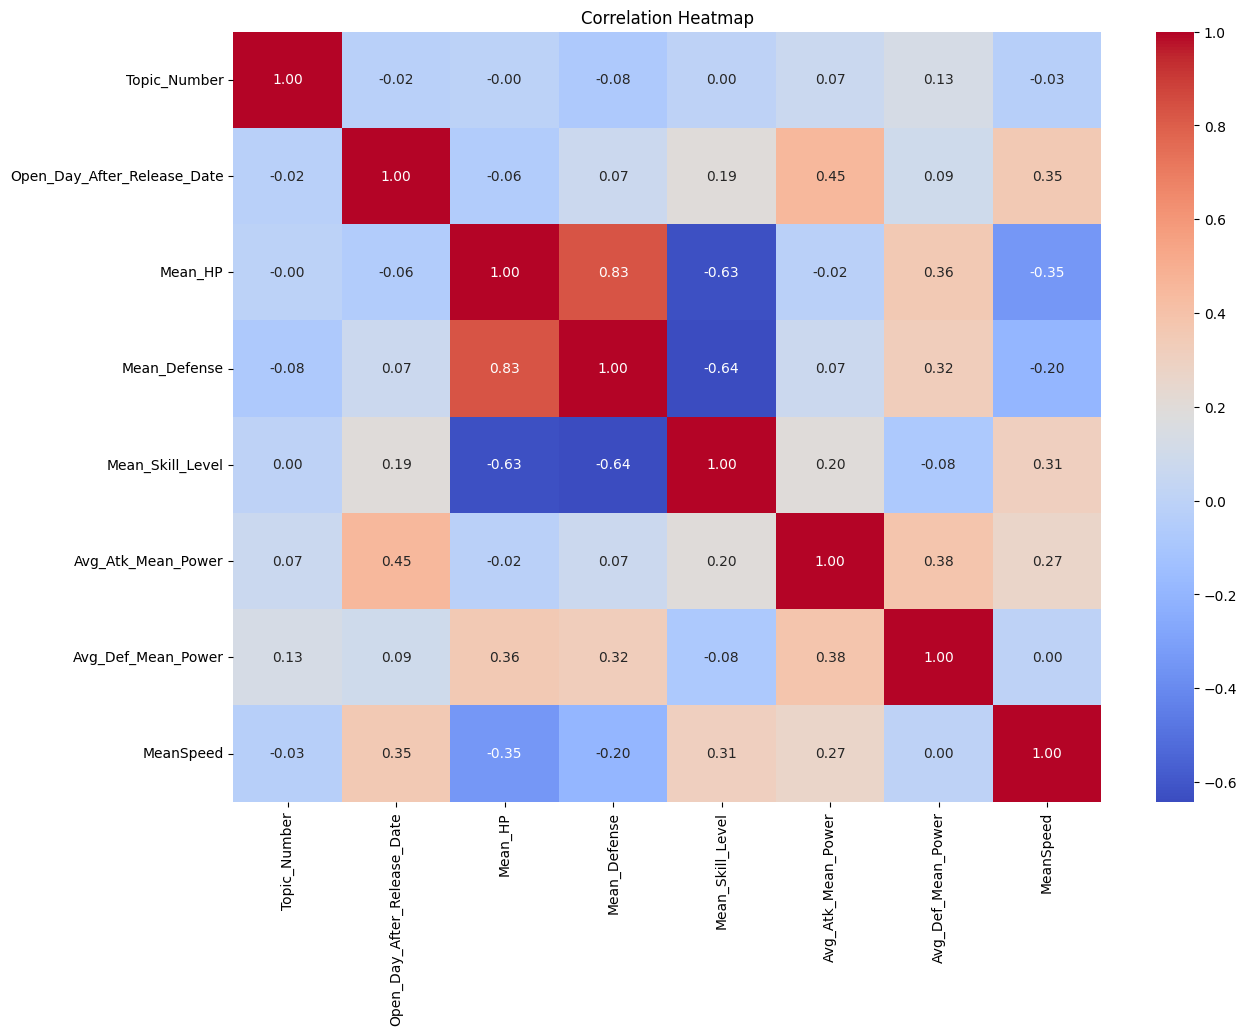

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# 상관 행렬 (히트맵)
plt.figure(figsize=(14, 10))
corr_matrix = drop_identity_id_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [41]:
output_csv_path = "./conclusion/processed_info_update.csv"
merged_df.to_csv(output_csv_path, index=False)

In [42]:
import pandas as pd
merged_df = pd.read_csv("./conclusion/processed_info.csv")

In [43]:
pd.set_option('display.max_rows', None)
display(merged_df.head(125))

Identity_ID  Topic_Number  Open_Day_After_Release_Date  Mean_HP  \
0          10101             7                            0   135.24   
1          10102             1                            0   153.92   
2          10103             3                            0   124.14   
3          10104             7                          108   124.14   
4          10105             1                          199   137.02   
5          10106             4                          255   148.62   
6          10107             3                          283   129.96   
7          10108             9                          332   153.92   
8          10109             0                          444   131.20   
9          10110             0                          556   124.14   
10         10201            11                            0   158.00   
11         10202             4                            0   165.76   
12         10203             2                            0   129.96   
13         10204             0                           24   124.14   
14         10205             2                          164   153.92   
15         10206             5                          192   137.20   
16         10207             1                          241   153.92   
17         10208             3                          360   140.00   
18         10209             8                          402   144.90   
19         10210             4                          528   124.14   
20         10301             0                            0   124.14   
21         10302             4                            0   137.02   
22         10303             2                            0   129.96   
23         10304             0                           66   153.92   
24         10305             2                          143   130.14   
25         10306             0                          269   161.48   
26         10307            10                          318   153.92   
27         10308             3                          360   134.20   
28         10309             1                          486   178.14   
29         10310             0                          654   118.34   
30         10401            12                            0   124.14   
31         10402             5                            0   118.34   
32         10403             0                            0   137.02   
33         10404             0                           24   131.20   
34         10405             4                          178   124.14   
35         10406             3                          262   142.30   
36         10407             6                          374   142.30   
37         10408             2                          416   131.20   
38         10409             1                          472   132.20   
39         10410             0                          556   128.68   
40         10501             1                            0   169.10   
41         10502             6                            0   153.92   
42         10503             4                            0   148.62   
43         10504             0                           10   185.96   
44         10505             1                           94   144.90   
45         10506             4                          136   171.50   
46         10507             0                          269   153.92   
47         10508            12                          360   151.62   
48         10509             5                          395   142.30   
49         10510             9                          500   153.92   
50         10511             2                          591   129.96   
51         10601             7                            0   124.14   
52         10602             0                            0   142.30   
53         10603             0                            0   142.30   
54         10604             6               

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

df = drop_identity_id_df.copy()

# 2. 기본 통계 분석
print(df.describe())

       Topic_Number  Open_Day_After_Release_Date     Mean_HP  Mean_Defense  \
count    126.000000                   126.000000  126.000000    126.000000   
mean       3.785714                   219.777778  143.142381     25.635556   
std        3.409650                   215.664216   16.995010      2.588748   
min        0.000000                     0.000000  112.760000     21.700000   
25%        1.000000                     0.000000  129.960000     23.560000   
50%        3.000000                   164.000000  142.300000     25.500000   
75%        6.000000                   393.250000  153.920000     27.500000   
max       12.000000                   682.000000  194.960000     30.500000   

       Mean_Skill_Level  Avg_Atk_Mean_Power  Avg_Def_Mean_Power   MeanSpeed  
count        126.000000          126.000000          126.000000  126.000000  
mean          27.230397           12.005563           14.021825    4.466270  
std            1.756094            1.182249            2.041083

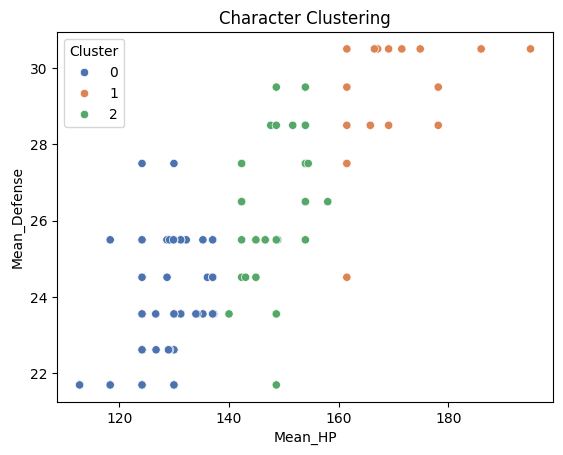

In [45]:
# 4. 클러스터링 분석 (K-Means)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df[["Mean_HP", "Mean_Defense", "Avg_Def_Mean_Power"]])
sns.scatterplot(x=df["Mean_HP"], y=df["Mean_Defense"], hue=df["Cluster"], palette="deep")
plt.title("Character Clustering")
plt.show()

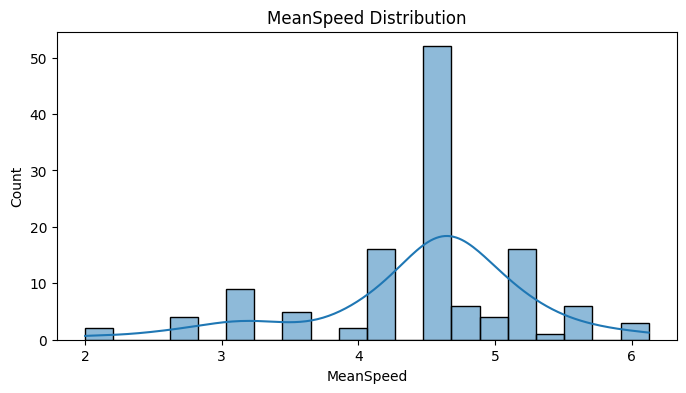

In [46]:
# 5. 데이터 분포 확인
plt.figure(figsize=(8,4))
sns.histplot(df["MeanSpeed"], bins=20, kde=True)
plt.title("MeanSpeed Distribution")
plt.show()

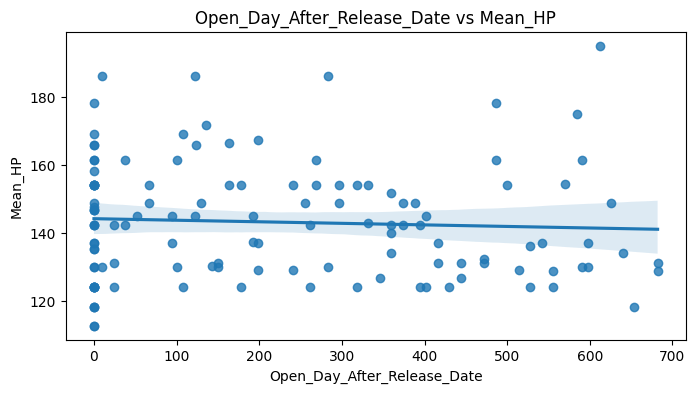

In [47]:
# 6. 값의 변화 추적 (회귀 분석)
plt.figure(figsize=(8,4))
sns.regplot(x="Open_Day_After_Release_Date", y="Mean_HP", data=df)
plt.title("Open_Day_After_Release_Date vs Mean_HP")
plt.show()

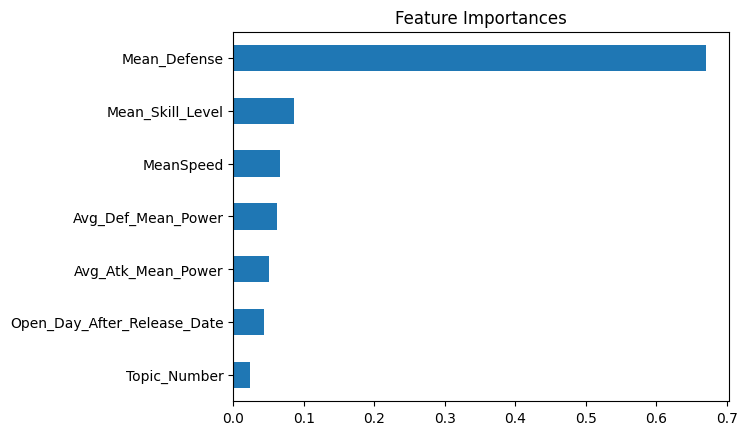

In [48]:
# 7. 중요 변수 선정 (랜덤 포레스트)
X = df.drop(columns=["Mean_HP", "Cluster"])
y = df["Mean_HP"]
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", title="Feature Importances")
plt.show()

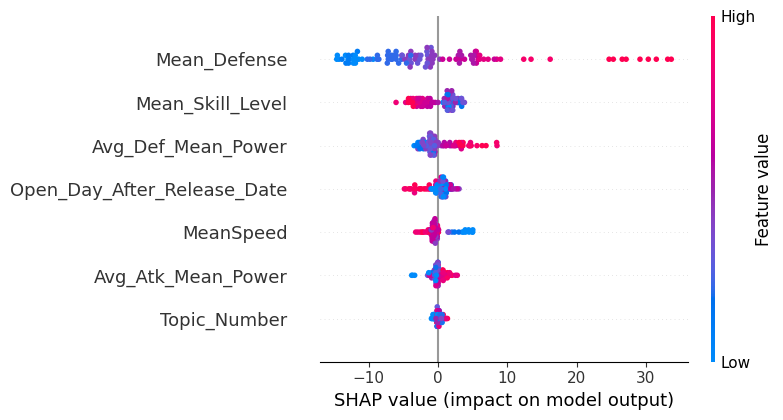

In [51]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

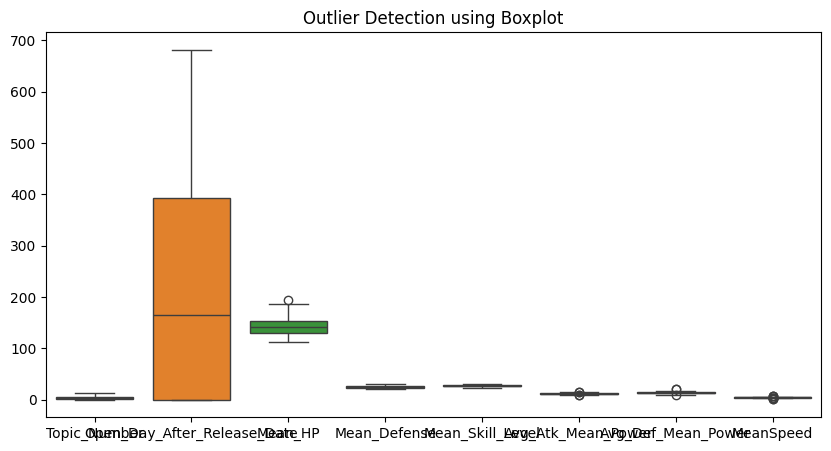

이상치 제거 후 데이터 개수: 110
스피어만 상관 계수 (Mean_HP vs Mean_Defense): 0.78


/var/folders/27/r1qdd08x0fx8nvdhy823ntqw0000gn/T/ipykernel_8411/607324006.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["DBSCAN_Cluster"] = dbscan.fit_predict(df_cleaned[["Mean_HP", "Mean_Defense", "Mean_Skill_Level"]])


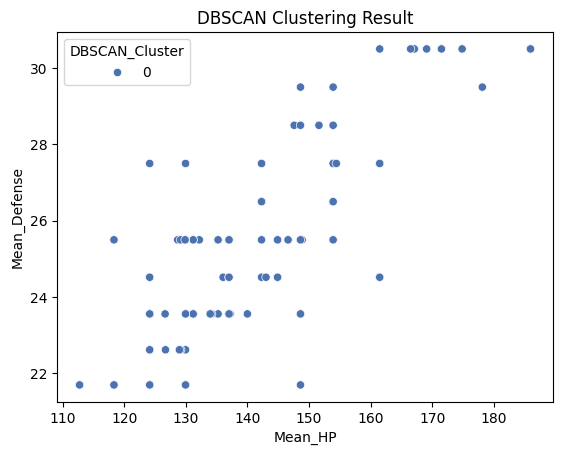

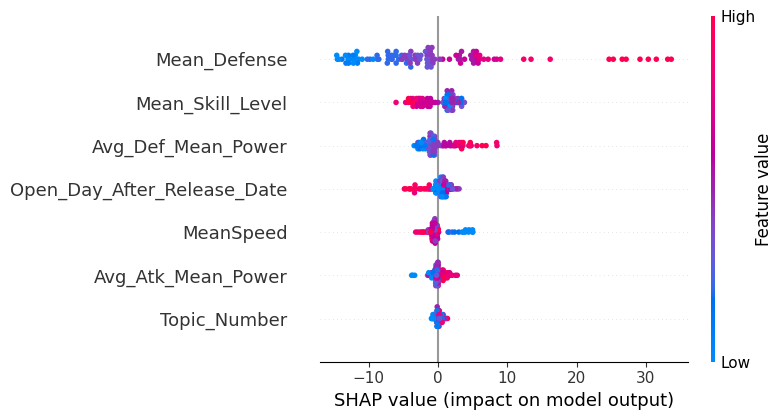

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
import shap

# 데이터 생성
df = drop_identity_id_df.copy()

# 1. **이상치 탐색 (Boxplot & IQR)**
plt.figure(figsize=(10,5))
sns.boxplot(data=df)
plt.title("Outlier Detection using Boxplot")
plt.show()

# IQR 방법으로 이상치 제거
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"이상치 제거 후 데이터 개수: {len(df_cleaned)}")

# 2. **비선형 관계 분석 (스피어만 상관 분석)**
corr_spearman, _ = spearmanr(df_cleaned["Mean_HP"], df_cleaned["Mean_Defense"])
print(f"스피어만 상관 계수 (Mean_HP vs Mean_Defense): {corr_spearman:.2f}")

# 3. **DBSCAN을 활용한 클러스터링**
dbscan = DBSCAN(eps=30, min_samples=5)
df_cleaned["DBSCAN_Cluster"] = dbscan.fit_predict(df_cleaned[["Mean_HP", "Mean_Defense", "Mean_Skill_Level"]])
sns.scatterplot(x=df_cleaned["Mean_HP"], y=df_cleaned["Mean_Defense"], hue=df_cleaned["DBSCAN_Cluster"], palette="deep")
plt.title("DBSCAN Clustering Result")
plt.show()

# 4. **SHAP을 활용한 모델 해석**
X = df_cleaned.drop(columns=["Mean_HP", "DBSCAN_Cluster"])
y = df_cleaned["Mean_HP"]
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

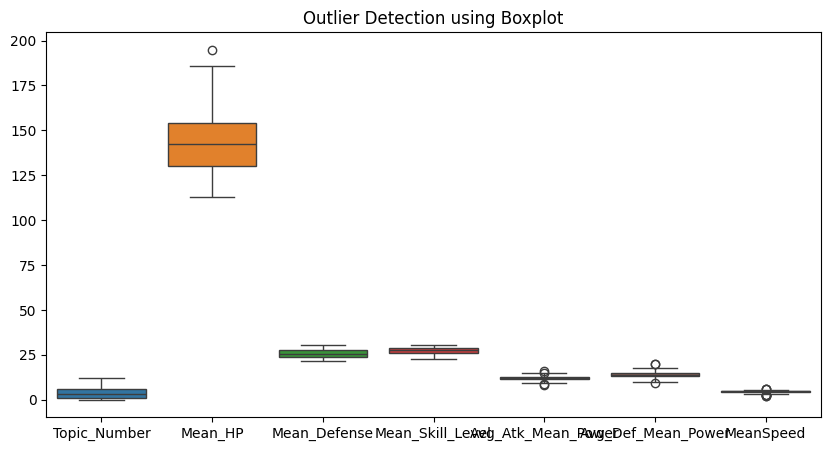

In [52]:
X = df.drop(columns=["Open_Day_After_Release_Date"])
# 1. **이상치 탐색 (Boxplot & IQR)**
plt.figure(figsize=(10,5))
sns.boxplot(data=X)
plt.title("Outlier Detection using Boxplot")
plt.show()

        Identity_ID  Topic_Number  Open_Day_After_Release_Date     Mean_HP  \
count     11.000000     11.000000                    11.000000   11.000000   
mean   10606.000000      4.272727                   242.090909  142.049091   
std        3.316625      3.466725                   248.423209   16.784708   
min    10601.000000      0.000000                     0.000000  124.140000   
25%    10603.500000      1.500000                    19.000000  131.200000   
50%    10606.000000      4.000000                   178.000000  142.300000   
75%    10608.500000      6.500000                   402.000000  142.660000   
max    10611.000000     10.000000                   682.000000  185.960000   

       Mean_Defense  Mean_Skill_Level  Avg_Atk_Mean_Power  Avg_Def_Mean_Power  \
count     11.000000         11.000000           11.000000           11.000000   
mean      25.972727         26.910909           12.345103           14.159091   
std        2.134484          1.377670            1.280

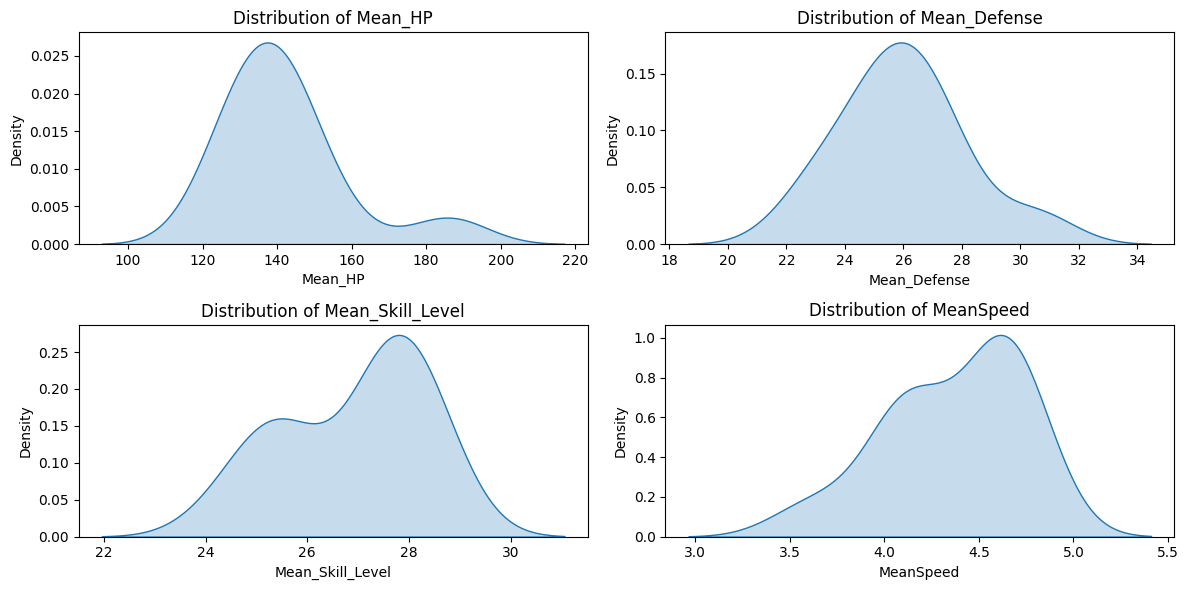

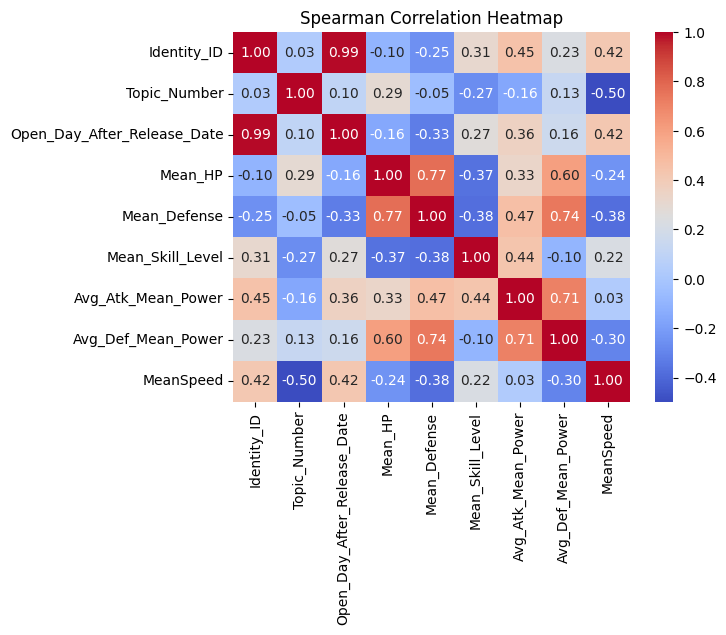

/var/folders/27/r1qdd08x0fx8nvdhy823ntqw0000gn/T/ipykernel_13568/4291386579.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["PCA1"] = pca_result[:,0]
/var/folders/27/r1qdd08x0fx8nvdhy823ntqw0000gn/T/ipykernel_13568/4291386579.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["PCA2"] = pca_result[:,1]


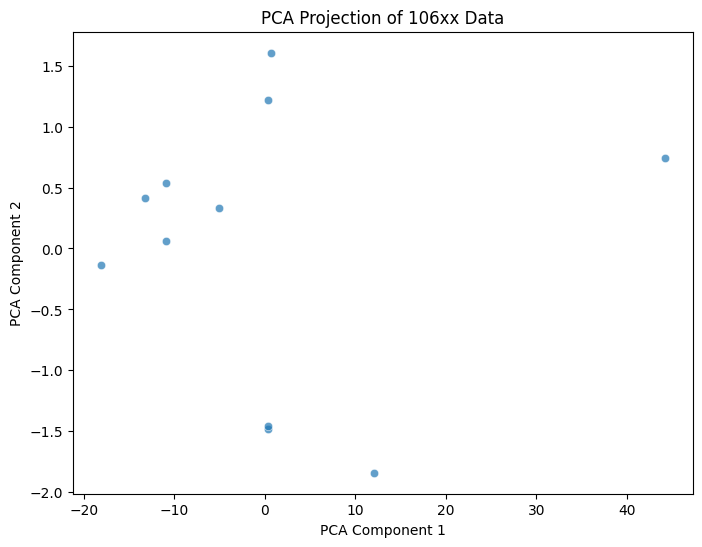

/var/folders/27/r1qdd08x0fx8nvdhy823ntqw0000gn/T/ipykernel_13568/4291386579.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["KMeans_Cluster"] = kmeans.fit_predict(df_filtered[["Mean_HP", "Mean_Defense", "Mean_Skill_Level"]])


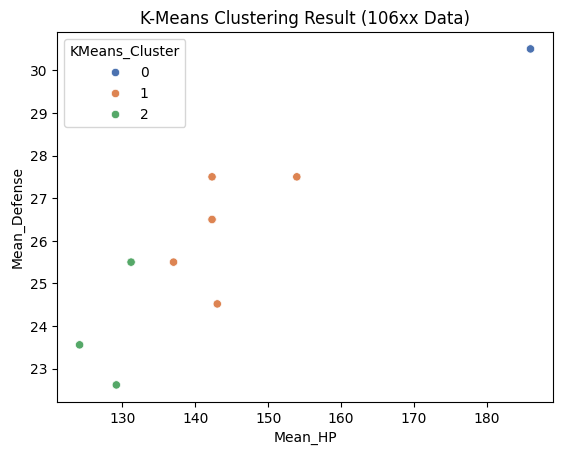

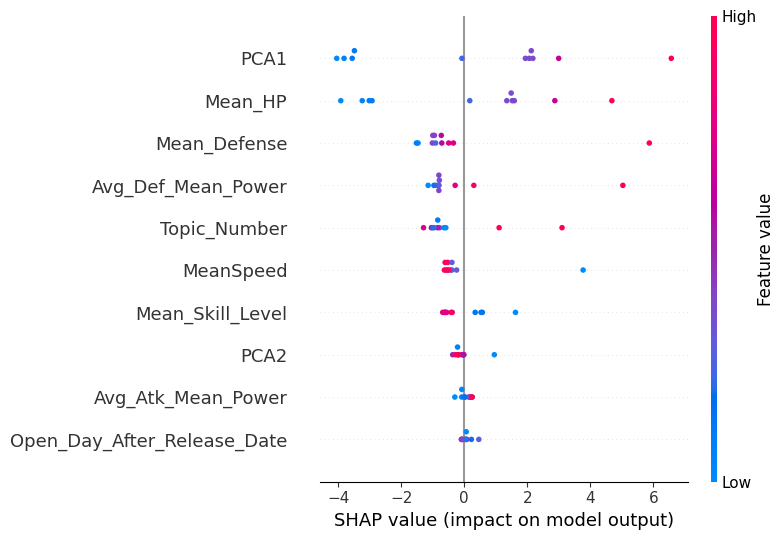

             Topic_Number  Open_Day_After_Release_Date  Mean_HP  Mean_Defense  \
Identity_ID                                                                     
10601                 7.0                          0.0   124.14         23.56   
10602                 0.0                          0.0   142.30         26.50   
10603                 0.0                          0.0   142.30         27.50   
10604                 6.0                         38.0   142.30         26.50   
10605                10.0                        122.0   185.96         30.50   
10606                 4.0                        178.0   153.92         27.50   
10607                 2.0                        241.0   129.18         22.62   
10608                 9.0                        332.0   143.02         24.52   
10609                 1.0                        472.0   131.20         25.50   
10610                 5.0                        598.0   137.02         25.50   
10611                 3.0   

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import shap

# 데이터 생성 (예시)
np.random.seed(42)
df = merged_df.copy()

# 1️⃣ **106xx 데이터만 필터링**
df_filtered = df[df["Identity_ID"].astype(str).str.match(r"^106\d{2}$")]

# 2️⃣ **기본 기술 통계 확인**
print(df_filtered.describe())

# 3️⃣ **각 컬럼의 분포 시각화 (KDE 플롯)**
plt.figure(figsize=(12,6))
for i, col in enumerate(["Mean_HP", "Mean_Defense", "Mean_Skill_Level", "MeanSpeed"]):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(df_filtered[col], fill=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# 4️⃣ **변수 간 상관 관계 분석 (Spearman)**
corr_matrix = df_filtered.corr(method="spearman")
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation Heatmap")
plt.show()

# 5️⃣ **PCA를 활용한 차원 축소 후 시각화**
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_filtered[["Mean_HP", "Mean_Defense", "Mean_Skill_Level", "MeanSpeed"]])
df_filtered["PCA1"] = pca_result[:,0]
df_filtered["PCA2"] = pca_result[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_filtered["PCA1"], y=df_filtered["PCA2"], alpha=0.7)
plt.title("PCA Projection of 106xx Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# 6️⃣ **K-Means 클러스터링**
kmeans = KMeans(n_clusters=3, random_state=42)
df_filtered["KMeans_Cluster"] = kmeans.fit_predict(df_filtered[["Mean_HP", "Mean_Defense", "Mean_Skill_Level"]])

sns.scatterplot(x=df_filtered["Mean_HP"], y=df_filtered["Mean_Defense"], hue=df_filtered["KMeans_Cluster"], palette="deep")
plt.title("K-Means Clustering Result (106xx Data)")
plt.show()

# 7️⃣ **SHAP을 활용한 주요 특징 분석**
X = df_filtered.drop(columns=["Identity_ID", "KMeans_Cluster"])
y = df_filtered["Mean_HP"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

# 8️⃣ **각 Identity_ID별 평균값 그룹화**
grouped = df_filtered.groupby("Identity_ID").mean()
print(grouped)


In [29]:
import csv

# 기본 평균값
identity_id = 10602
mean_hp = 142.30  # 평균 HP
mean_defense = 26.5  # 평균 방어력
mean_skill_level = 25.5  # 평균 스킬 레벨

# Level 1부터 Level 50까지 값을 0.5에서 1.5로 선형적으로 증가시키기 위한 계산
level_count = 50  # 총 레벨 수

# 증가 범위 설정 (0.5 -> 1.5로 증가)
hp_increase = (1.5 - 0.5) / (level_count - 1)  # Level 1 ~ Level 50까지 증가
defense_increase = (1.5 - 0.5) / (level_count - 1)
skill_level_increase = (1.5 - 0.5) / (level_count - 1)

# CSV 파일 생성
filename = "generated_identity_data.csv"
with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Identity_ID", "Level", "HP", "Skill_Level", "Skills"])

    for level in range(1, level_count + 1):
        # 평균값을 기준으로 선형적으로 증가하는 HP 계산
        hp_multiplier = 0.5 + hp_increase * (level - 1)
        hp = int(round(mean_hp * hp_multiplier))  # 반올림 후 정수로 변환

        # 평균값을 기준으로 선형적으로 증가하는 스킬 레벨 계산
        skill_level_multiplier = 0.5 + skill_level_increase * (level - 1)
        skill_level = int(round(mean_skill_level * skill_level_multiplier))  # 반올림 후 정수로 변환

        # 평균값을 기준으로 선형적으로 증가하는 방어력 계산
        defense_multiplier = 0.5 + defense_increase * (level - 1)
        defense = int(round(mean_defense * defense_multiplier))  # 반올림 후 정수로 변환

        skills = [
            f"SKILL 1: {skill_level}",
            f"SKILL 2: {skill_level}",
            f"SKILL 3: {skill_level}",
            f"DEFENSE: {defense}",
        ]

        writer.writerow([identity_id, level, hp, skill_level, str(skills)])

print(f"CSV 파일이 생성되었습니다: {filename}")


CSV 파일이 생성되었습니다: generated_identity_data.csv


In [28]:
import csv

# 평균값 설정 (예시 값)
mean_values = {
    "Identity_ID": 10601,
    "Mean_HP": 124.14,
    "Mean_Defense": 23.56,
    "Mean_Skill_Level": 27.5,
    "Avg_Mean_Power": 10.869048,
    "Avg_Def_Mean_Power": 12.00,
    "MeanSpeed": 4.125
}

# Level 1부터 Level 50까지 값을 0.5에서 1.5로 선형적으로 증가시키기 위한 계산
level_count = 50  # 총 레벨 수

# 증가 범위 설정 (0.5 -> 1.5로 증가)
hp_increase = (1.5 - 0.5) / (level_count - 1)  # Level 1 ~ Level 50까지 증가
defense_increase = (1.5 - 0.5) / (level_count - 1)
skill_level_increase = (1.5 - 0.5) / (level_count - 1)

# CSV 파일 생성
filename = "generated_identity_data.csv"
with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # 헤더 작성
    writer.writerow([
        "Identity_ID", 
        "Mean_HP", 
        "Mean_Defense", 
        "Mean_Skill_Level", 
        "Avg_Mean_Power", 
        "Avg_Def_Mean_Power", 
        "MeanSpeed"
    ])
    
    # Level별 계산 시작
    for level in range(1, level_count + 1):
        # 평균값을 기준으로 선형적으로 증가하는 HP 계산
        hp_multiplier = 0.5 + hp_increase * (level - 1)
        hp = int(round(mean_values["Mean_HP"] * hp_multiplier))  # 반올림 후 정수로 변환

        # 평균값을 기준으로 선형적으로 증가하는 스킬 레벨 계산
        skill_level_multiplier = 0.5 + skill_level_increase * (level - 1)
        skill_level = int(round(mean_values["Mean_Skill_Level"] * skill_level_multiplier))  # 반올림 후 정수로 변환

        # 평균값을 기준으로 선형적으로 증가하는 방어력 계산
        defense_multiplier = 0.5 + defense_increase * (level - 1)
        defense = int(round(mean_values["Mean_Defense"] * defense_multiplier))  # 반올림 후 정수로 변환

        # skills 리스트 작성 (예시)
        skills = [
            f"SKILL 1: {skill_level}",
            f"SKILL 2: {skill_level}",
            f"SKILL 3: {skill_level}",
            f"DEFENSE: {defense}",
        ]

        # 해당 레벨에 대한 데이터를 CSV에 작성
        writer.writerow([
            mean_values["Identity_ID"],
            mean_values["Mean_HP"],
            mean_values["Mean_Defense"],
            mean_values["Mean_Skill_Level"],
            mean_values["Avg_Mean_Power"],
            mean_values["Avg_Def_Mean_Power"],
            mean_values["MeanSpeed"]
        ])

print(f"CSV 파일이 생성되었습니다: {filename}")


CSV 파일이 생성되었습니다: generated_identity_data.csv


In [17]:
df_filtered.to_csv("./csv/origin_identity_data.csv")

In [31]:
import csv

# 기본 평균값
identity_id = 10602
mean_hp = 142.30  # 평균 HP
mean_defense = 26.5  # 평균 방어력
mean_skill_level = 25.5  # 평균 스킬 레벨

# Level 1부터 Level 50까지 값을 0.5에서 1.5로 선형적으로 증가시키기 위한 계산
level_count = 50  # 총 레벨 수

# 증가 범위 설정 (0.5 -> 1.5로 증가)
hp_increase = (1.5 - 0.5) / (level_count - 1)  # Level 1 ~ Level 50까지 증가
defense_increase = (2 - 0.5) / (level_count - 1)
skill_level_increase = (2 - 0.5) / (level_count - 1)

# CSV 파일 생성
filename = "generated_identity_data.csv"
with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Identity_ID", "Level", "HP", "Skill_Level", "Skills"])

    for level in range(1, level_count + 1):
        # 평균값을 기준으로 선형적으로 증가하는 HP 계산
        hp_multiplier = 0.5 + hp_increase * (level - 1)
        hp = round(mean_hp * hp_multiplier, 2)
        
        # 평균값을 기준으로 선형적으로 증가하는 스킬 레벨 계산
        skill_level_multiplier = 0.5 + skill_level_increase * (level - 1)
        skill_level = round(mean_skill_level * skill_level_multiplier, 2)

        # 평균값을 기준으로 선형적으로 증가하는 방어력 계산
        defense_multiplier = 0.5 + defense_increase * (level - 1)
        defense = round(mean_defense * defense_multiplier, 2)

        writer.writerow([identity_id, level, hp, skill_level, defense])

print(f"CSV 파일이 생성되었습니다: {filename}")


CSV 파일이 생성되었습니다: generated_identity_data.csv


In [29]:
import itertools
import numpy as np

def calculate_expression(expression, data):
    """주어진 연산식을 계산합니다."""
    try:
        local_vars = {
            'Mean_HP': data['Mean_HP'],
            'Mean_Defense': data['Mean_Defense'],
            'Mean_Skill_Level': data['Mean_Skill_Level'],
            'MeanSpeed': data['MeanSpeed'],
            'Avg_Mean_Power': data['Avg_Mean_Power'],
            'Avg_Def_Mean_Power': data['Avg_Def_Mean_Power']
        }
        result = eval(expression, {}, local_vars)  # 안전한 환경에서 연산 실행
        return result
    except (TypeError, SyntaxError, NameError, ZeroDivisionError):
        return None  # 잘못된 연산식은 None 반환

def generate_combinations(variables, operators):
    """6개의 항을 모두 포함하는 연산 조합만 생성합니다."""
    combinations = []
    
    for operator_combination in itertools.product(operators, repeat=5):  # 5개의 연산자 필요
        expression = variables[0]
        for i in range(5):
            expression += f" {operator_combination[i]} {variables[i + 1]}"
        combinations.append(expression)
    
    return combinations

def calculate_and_evaluate(data):
    """모든 6항 연산 조합을 계산하고 평가합니다."""
    variables = ['Mean_HP', 'Mean_Defense', 'Mean_Skill_Level', 'MeanSpeed', 'Avg_Mean_Power', 'Avg_Def_Mean_Power']
    operators = ['+', '-', '*', '/']

    all_combinations = generate_combinations(variables, operators)
    results = []

    for expression in all_combinations:
        values = []
        for row in data:  # 각 데이터 행에 대해 계산
            row_data = {
                'Mean_HP': row[3],
                'Mean_Defense': row[4],
                'Mean_Skill_Level': row[5],
                'MeanSpeed': row[6],
                'Avg_Mean_Power': row[7],
                'Avg_Def_Mean_Power': row[8]
            }
            result = calculate_expression(expression, row_data)
            if result is not None:
                values.append(result)
        
        if values:  # 계산 결과가 있는 경우에만 처리
            std = np.std(values)
            mean = np.mean(values)
            results.append((expression, std, mean))

    # 표준편차가 낮은 순으로 정렬
    results.sort(key=lambda x: x[1])
    return results

# 예제 데이터 (6개의 컬럼: Mean_HP, Mean_Defense, Mean_Skill_Level, MeanSpeed, Avg_Mean_Power, Avg_Def_Mean_Power)
data = merged_df.copy()

# 데이터 분석 실행
data_array = np.array(data)
results = calculate_and_evaluate(data_array)
df_results = pd.DataFrame(results, columns=["Expression", "Mean", "Standard Deviation"])

display(df_results.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))


In [54]:
import itertools
import numpy as np

def calculate_expression(expression, data):
    """주어진 연산식을 계산합니다."""
    try:
        local_vars = {
            'Mean_HP': data['Mean_HP'],
            'Mean_Defense': data['Mean_Defense'],
            'Mean_Skill_Level': data['Mean_Skill_Level'],
            'MeanSpeed': data['MeanSpeed'],
            'Avg_Mean_Power': data['Avg_Mean_Power'],
            'Avg_Def_Mean_Power': data['Avg_Def_Mean_Power']
        }
        result = eval(expression, {}, local_vars)  # 안전한 환경에서 연산 실행
        return result
    except (TypeError, SyntaxError, NameError, ZeroDivisionError):
        return None  # 잘못된 연산식은 None 반환

def generate_combinations(variables, operators):
    """6개의 항을 모두 포함하는 연산 조합만 생성합니다."""
    combinations = []
    
    for operator_combination in itertools.product(operators, repeat=5):  # 5개의 연산자 필요
        expression = variables[0]
        for i in range(5):
            expression += f" {operator_combination[i]} {variables[i + 1]}"
        combinations.append(expression)
    
    return combinations

def calculate_and_evaluate(data):
    """모든 6항 연산 조합을 계산하고 평가합니다."""
    variables = ['Mean_HP', 'Mean_Defense', 'Mean_Skill_Level', 'MeanSpeed', 'Avg_Mean_Power', 'Avg_Def_Mean_Power']
    operators = ['+', '-', '*', '/']

    all_combinations = generate_combinations(variables, operators)
    results = []

    for expression in all_combinations:
        values = []
        for row in data:  # 각 데이터 행에 대해 계산
            row_data = {
                'Mean_HP': row[3],
                'Mean_Defense': row[4],
                'Mean_Skill_Level': row[5],
                'MeanSpeed': row[6],
                'Avg_Mean_Power': row[7],
                'Avg_Def_Mean_Power': row[8]
            }
            result = calculate_expression(expression, row_data)
            if result is not None:
                values.append(result)

            # 1. 나눗셈 조합 공식
            if row_data['Mean_Defense'] and row_data['MeanSpeed'] and row_data['Avg_Def_Mean_Power']:  # 0으로 나누는 오류 방지
                formula1 = (row_data['Mean_HP'] / row_data['Mean_Defense']) * (row_data['Mean_Skill_Level'] / row_data['MeanSpeed']) * (row_data['Avg_Mean_Power'] / row_data['Avg_Def_Mean_Power'])
                values.append(formula1)

            # 2. Z-score 변환 후 평균
            features = [row_data['Mean_HP'], row_data['Mean_Defense'], row_data['Mean_Skill_Level'], row_data['MeanSpeed'], row_data['Avg_Mean_Power'], row_data['Avg_Def_Mean_Power']]
            if np.std(features) != 0:  # 표준편차가 0이 아닐 때만 Z-score 계산
                z_scores = [(x - np.mean(features)) / np.std(features) for x in features]
                formula2 = np.mean(z_scores)
                values.append(formula2)

            # 3. 중앙값과 IQR 활용
            median_values = np.median(features)
            formula3 = median_values
            values.append(formula3)

            # 4. MAD(Mean Absolute Deviation) 활용
            mad = np.mean(np.abs(np.array(features) - np.median(features)))
            if mad != 0:  # MAD가 0이 아닐 때만 적용
                formula4 = (row_data['Mean_HP'] - median_values) / mad
                values.append(formula4)

        if values:  # 계산 결과가 있는 경우에만 처리
            std = np.std(values)
            mean = np.mean(values)
            results.append((expression, std, mean))

    # 표준편차가 낮은 순으로 정렬
    results.sort(key=lambda x: x[1])
    return results


# 예제 데이터 (6개의 컬럼: Mean_HP, Mean_Defense, Mean_Skill_Level, MeanSpeed, Avg_Mean_Power, Avg_Def_Mean_Power)
data = merged_df.copy()

# 데이터 분석 실행
data_array = np.array(data)
results = calculate_and_evaluate(data_array)
df_results = pd.DataFrame(results, columns=["Expression", "Mean", "Standard Deviation"])

display(df_results.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))


In [55]:
results = calculate_and_evaluate(data_array)
df_results = pd.DataFrame(results)

display(df_results.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

In [35]:
import itertools
import numpy as np
import pandas as pd

def calculate_and_evaluate(data):
    variables = ['Mean_HP', 'Mean_Defense', 'Mean_Skill_Level', 'MeanSpeed', 'Avg_Mean_Power', 'Avg_Def_Mean_Power']

    results_division = []
    results_zscore = []
    results_median = []
    results_mad = []

    for row in data:  # 각 데이터 행에 대해 계산
        row_data = {
            'Mean_HP': row[3],
            'Mean_Defense': row[4],
            'Mean_Skill_Level': row[5],
            'MeanSpeed': row[6],
            'Avg_Mean_Power': row[7],
            'Avg_Def_Mean_Power': row[8]
        }

        # 1. 나눗셈 조합 공식
        if row_data['Mean_Defense'] and row_data['MeanSpeed'] and row_data['Avg_Def_Mean_Power']:  # 0으로 나누는 오류 방지
            formula1 = (row_data['Mean_HP'] / row_data['Mean_Defense']) * (row_data['Mean_Skill_Level'] / row_data['MeanSpeed']) * (row_data['Avg_Mean_Power'] / row_data['Avg_Def_Mean_Power'])
            values_division.append(formula1)

        # 2. Z-score 변환 후 평균
        features = [row_data['Mean_HP'], row_data['Mean_Defense'], row_data['Mean_Skill_Level'], row_data['MeanSpeed'], row_data['Avg_Mean_Power'], row_data['Avg_Def_Mean_Power']]
        if np.std(features) != 0:  # 표준편차가 0이 아닐 때만 Z-score 계산
            z_scores = [(x - np.mean(features)) / np.std(features) for x in features]
            formula2 = np.mean(z_scores)
            values_zscore.append(formula2)

        # 3. 중앙값과 IQR 활용
        median_values = np.median(features)
        values_median.append(median_values)

        # 4. MAD(Mean Absolute Deviation) 활용
        mad = np.mean(np.abs(np.array(features) - np.median(features)))
        if mad != 0:  # MAD가 0이 아닐 때만 적용
            formula4 = (row_data['Mean_HP'] - median_values) / mad
            values_mad.append(formula4)

    # 각 항목에 대해 계산된 값들을 따로 리스트에 저장
    if values_division:
        std_div = np.std(values_division)
        mean_div = np.mean(values_division)
        results_division.append(("나눗셈 조합 공식", mean_div, std_div))

    if values_zscore:
        std_zscore = np.std(values_zscore)
        mean_zscore = np.mean(values_zscore)
        results_zscore.append(("Z-Score 변환 후 평균", mean_zscore, std_zscore))

    if values_median:
        std_median = np.std(values_median)
        mean_median = np.mean(values_median)
        results_median.append(("중앙값과 IQR 활용", mean_median, std_median))

    if values_mad:
        std_mad = np.std(values_mad)
        mean_mad = np.mean(values_mad)
        results_mad.append(("MAD 활용", mean_mad, std_mad))

    return results_division, results_zscore, results_median, results_mad


# 예제 데이터 (6개의 컬럼: Mean_HP, Mean_Defense, Mean_Skill_Level, MeanSpeed, Avg_Mean_Power, Avg_Def_Mean_Power)
data = merged_df.copy()

# 데이터 분석 실행
data_array = np.array(data)
results_division, results_zscore, results_median, results_mad = calculate_and_evaluate(data_array)

# 각 계산 결과 출력
df_results_division = pd.DataFrame(results_division, columns=["Expression", "Mean", "Standard Deviation"])
df_results_zscore = pd.DataFrame(results_zscore, columns=["Expression", "Mean", "Standard Deviation"])
df_results_median = pd.DataFrame(results_median, columns=["Expression", "Mean", "Standard Deviation"])
df_results_mad = pd.DataFrame(results_mad, columns=["Expression", "Mean", "Standard Deviation"])

# 결과 출력
display(df_results_division.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_zscore.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_median.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_mad.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

# 각 계산된 결과 확인
print("나눗셈 조합 공식 결과:")
print(df_results_division)
print("Z-Score 변환 후 평균 결과:")
print(df_results_zscore)
print("중앙값과 IQR 활용 결과:")
print(df_results_median)
print("MAD 활용 결과:")
print(df_results_mad)


나눗셈 조합 공식 결과:
     Expression        Mean  Standard Deviation
0     나눗셈 조합 공식  134.128314           93.769916
1     나눗셈 조합 공식  129.662044           89.421285
2     나눗셈 조합 공식  156.197262          115.980702
3     나눗셈 조합 공식  126.516785           86.257244
4     나눗셈 조합 공식  120.106489           79.808886
...         ...         ...                 ...
1019  나눗셈 조합 공식   20.906190           22.751002
1020  나눗셈 조합 공식   23.111089           20.756505
1021  나눗셈 조합 공식   18.644819           24.845813
1022  나눗셈 조합 공식   20.880121           22.774886
1023  나눗셈 조합 공식   20.877470           22.777316

[1024 rows x 3 columns]
Z-Score 변환 후 평균 결과:
           Expression          Mean  Standard Deviation
0     Z-Score 변환 후 평균 -5.727341e-18        7.768569e-17
1     Z-Score 변환 후 평균 -5.727341e-18        7.768569e-17
2     Z-Score 변환 후 평균 -5.727341e-18        7.768569e-17
3     Z-Score 변환 후 평균 -5.727341e-18        7.768569e-17
4     Z-Score 변환 후 평균 -5.727341e-18        7.768569e-17
...               ...        

In [1]:
def generate_sequence(target_mean, base_mean=25.5, total_count=50):
    """
    주어진 평균을 만족하는 자연수 수열을 생성한다.
    :param target_mean: 목표 평균값
    :param base_mean: 기준 평균값 (기본값 25.5)
    :param total_count: 전체 원소 개수 (기본값 50)
    :return: 생성된 수열과 평균값 검증
    """
    # 1의 개수를 결정 (기준보다 낮으면 1을 추가)
    extra_ones = int(base_mean - target_mean)  # 1의 개수를 추가할 개수
    ones_count = 1 + extra_ones  # 최소 1개 이상 포함됨

    # 등차수열 부분 생성 (2부터 시작, 최대값은 50 - ones_count)
    max_value = total_count - ones_count
    arithmetic_seq = list(range(2, max_value + 1))

    # 전체 수열 생성
    sequence = [1] * ones_count + arithmetic_seq

    # 평균값 계산
    mean_value = sum(sequence) / len(sequence)

    return sequence, mean_value

# 조건에 맞춰 수열 생성 및 검증
seq_23_56, mean_23_56 = generate_sequence(23.56)
seq_22_62, mean_22_62 = generate_sequence(22.62)
seq_28_5, mean_28_5 = generate_sequence(28.5)

print("Sequence for mean 23.56:", seq_23_56, "Calculated Mean:", mean_23_56)
print("Sequence for mean 22.62:", seq_22_62, "Calculated Mean:", mean_22_62)
print("Sequence for mean 28.5:", seq_28_5, "Calculated Mean:", mean_28_5)


Sequence for mean 23.56: [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48] Calculated Mean: 24.020408163265305
Sequence for mean 22.62: [1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47] Calculated Mean: 23.06122448979592
Sequence for mean 28.5: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52] Calculated Mean: 27.0


In [4]:
def generate_sequence_recursive(target_mean, total_count=50, ones_count=1):
    """
    주어진 평균을 만족하는 자연수 수열을 재귀적으로 생성한다.
    :param target_mean: 목표 평균값
    :param total_count: 전체 원소 개수 (기본값 50)
    :param ones_count: 현재 1의 개수 (기본값 1)
    :return: 목표 평균을 만족하는 수열
    """
    # ones_count가 전체 길이의 절반을 넘어서면 평균 조정 불가능 -> 종료
    if ones_count > total_count // 2:
        return None
    
    # 최대값 설정 (1의 개수만큼 줄어듦)
    max_value = total_count - ones_count + 1  # 기존보다 1 증가하여 조정
    arithmetic_seq = list(range(2, max_value + 1))

    # 현재 수열 생성
    sequence = [1] * ones_count + arithmetic_seq
    mean_value = sum(sequence) / total_count

    # 목표 평균과 비교
    if round(mean_value, 2) == round(target_mean, 2):  # 소수점 비교
        return sequence
    elif mean_value > target_mean:  # 목표보다 크면 1을 추가하여 다시 시도
        return generate_sequence_recursive(target_mean, total_count, ones_count + 1)

    return None  # 이론적으로 도달하지 않음

# 목표 평균으로 수열 생성
seq_23_56 = generate_sequence_recursive(23.56)
seq_22_62 = generate_sequence_recursive(22.62)
seq_25_5 = generate_sequence_recursive(25.5)

# 결과 출력
print("Sequence for mean 23.56:", seq_23_56)
print("Sequence for mean 22.62:", seq_22_62)
print("Sequence for mean 25.5:", seq_25_5)


Sequence for mean 23.56: [1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
Sequence for mean 22.62: [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Sequence for mean 25.5: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [15]:
def generate_sequence_reverse(target_mean, total_count=50, min_value=1, max_value=50):
    """
    주어진 평균을 만족하는 자연수 수열을 재귀적으로 생성한다. 
    평균이 목표보다 크면 최소값을 하나씩 빼고 최대값을 +1하여 시도한다.
    :param target_mean: 목표 평균값
    :param total_count: 전체 원소 개수 (기본값 50)
    :param min_value: 최소값 (기본값 1)
    :param max_value: 최대값 (기본값 50)
    :return: 목표 평균을 만족하는 수열
    """
    # 수열 생성/
    arithmetic_seq = list(range(min_value, max_value + 1))
    
    # 평균 계산
    mean_value = sum(arithmetic_seq) / total_count

    # 목표 평균과 비교
    if round(mean_value, 2) == round(target_mean, 2):  # 소수점 비교
        return arithmetic_seq
    elif mean_value < target_mean:  # 목표보다 크면 최소값 하나를 빼고 최대값을 늘려서 시도
        return generate_sequence_reverse(target_mean, total_count, min_value + 1, max_value + 1)
    
    return None  # 목표 평균을 만족하는 수열을 찾지 못한 경우

# 테스트 값으로 수열 생성
seq_25_5 = generate_sequence_reverse(25.5)
seq_27_5 = generate_sequence_reverse(27.5)
seq_28_5 = generate_sequence_reverse(28.5)

# 결과 출력
print("Sequence for mean 25.5:", seq_25_5)
print("Sequence for mean 27:", seq_27_5)
print("Sequence for mean 28.5:", seq_28_5)

Sequence for mean 25.5: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Sequence for mean 27: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
Sequence for mean 28.5: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]


In [56]:
def generate_sequence(target_mean, total_count=50, min_value=1, max_value=50, ones_count=1):
    """
    주어진 평균을 만족하는 자연수 수열을 생성한다.
    평균이 목표보다 작으면 generate_sequence_recursive를 호출하고,
    평균이 목표보다 크면 generate_sequence_reverse를 호출한다.
    :param target_mean: 목표 평균값
    :param total_count: 전체 원소 개수 (기본값 50)
    :param min_value: 최소값 (기본값 1)
    :param max_value: 최대값 (기본값 50)
    :param ones_count: 현재 1의 개수 (기본값 1) -> recursive용
    :return: 목표 평균을 만족하는 수열
    """
    # 평균을 구하기 위한 현재 수열의 총합 계산
    if (sum(range(min_value, max_value + 1)) / total_count) < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value, max_value)
    else:
        return generate_sequence_recursive(target_mean, total_count, ones_count)

def generate_sequence_reverse(target_mean, total_count=50, min_value=1, max_value=50):
    """
    평균이 목표보다 크면 최소값을 하나씩 빼고 최대값을 +1하여 시도하는 함수
    :param target_mean: 목표 평균값
    :param total_count: 전체 원소 개수 (기본값 50)
    :param min_value: 최소값 (기본값 1)
    :param max_value: 최대값 (기본값 50)
    :return: 목표 평균을 만족하는 수열
    """
    arithmetic_seq = list(range(min_value, max_value + 1))
    mean_value = sum(arithmetic_seq) / total_count

    if round(mean_value, 2) >= round(target_mean, 2):
        return arithmetic_seq
    elif mean_value < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value + 1, max_value + 1)

    return None

def generate_sequence_recursive(target_mean, total_count=50, ones_count=1):
    """
    평균이 목표보다 작으면 1을 추가하여 재귀적으로 시도하는 함수
    :param target_mean: 목표 평균값
    :param total_count: 전체 원소 개수 (기본값 50)
    :param ones_count: 현재 1의 개수 (기본값 1)
    :return: 목표 평균을 만족하는 수열
    """
    if ones_count > total_count // 2:
        return None
    
    max_value = total_count - ones_count + 1
    arithmetic_seq = list(range(2, max_value + 1))

    sequence = [1] * ones_count + arithmetic_seq
    mean_value = sum(sequence) / total_count

    if round(mean_value, 2) == round(target_mean, 2):
        return sequence
    elif mean_value > target_mean:
        return generate_sequence_recursive(target_mean, total_count, ones_count + 1)

    return None

# 테스트 값으로 수열 생성
seq_25_5 = generate_sequence(25.5)
seq_27_5 = generate_sequence(27.5)
seq_28_5 = generate_sequence(28.5)
seq_23_56 = generate_sequence(23.56)
seq_22_62 = generate_sequence(22.62)
seq_30_5 = generate_sequence(30.5)
seq_28_16 = generate_sequence(28.166666666666664)
seq_21_7 = generate_sequence(21.7)

# 결과 출력
print("Sequence for mean 25.5:", seq_25_5)
print("Sequence for mean 27.5:", seq_27_5)
print("Sequence for mean 28.5:", seq_28_5)
print("Sequence for mean 23.56:", seq_23_56)
print("Sequence for mean 22.62:", seq_22_62)
print("Sequence for mean 30.5:", seq_30_5)
print("Sequence for mean 28.16:", seq_28_16)
print("Sequence for mean 21.7:", seq_21_7)


Sequence for mean 25.5: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Sequence for mean 27.5: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
Sequence for mean 28.5: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Sequence for mean 23.56: [1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
Sequence for mean 22.62: [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27

In [36]:
import numpy as np
import pandas as pd

def calculate_and_evaluate(data):
    # 각 요소의 평균 값을 계산합니다.
    mean_values = {
        'Mean_HP': np.mean(data[:, 3]),
        'Mean_Defense': np.mean(data[:, 4]),
        'Mean_Skill_Level': np.mean(data[:, 5]),
        'MeanSpeed': np.mean(data[:, 6]),
        'Avg_Mean_Power': np.mean(data[:, 7]),
        'Avg_Def_Mean_Power': np.mean(data[:, 8]),
    }

    # 결과를 저장할 리스트 초기화
    results = {
        'division': [],
        'zscore': [],
        'median': [],
        'mad': []
    }

    # 각 데이터 행에 대해 계산
    for row in data:
        row_data = {
            'Mean_HP': row[3],
            'Mean_Defense': row[4],
            'Mean_Skill_Level': row[5],
            'MeanSpeed': row[6],
            'Avg_Mean_Power': row[7],
            'Avg_Def_Mean_Power': row[8]
        }

        # 1. 나눗셈 조합 공식
        if row_data['Mean_Defense'] and row_data['MeanSpeed'] and row_data['Avg_Def_Mean_Power']:  # 0으로 나누는 오류 방지
            formula1 = (mean_values['Mean_HP'] / mean_values['Mean_Defense']) * (mean_values['Mean_Skill_Level'] / mean_values['MeanSpeed']) * (mean_values['Avg_Mean_Power'] / mean_values['Avg_Def_Mean_Power'])
            results['division'].append({
                'Mean_HP': row_data['Mean_HP'],
                'Mean_Defense': row_data['Mean_Defense'],
                'Mean_Skill_Level': row_data['Mean_Skill_Level'],
                'MeanSpeed': row_data['MeanSpeed'],
                'Avg_Mean_Power': row_data['Avg_Mean_Power'],
                'Avg_Def_Mean_Power': row_data['Avg_Def_Mean_Power'],
                'Formula1': formula1
            })

        # 2. Z-score 변환 후 평균
        features = [mean_values['Mean_HP'], mean_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']]
        if np.std(features) != 0:  # 표준편차가 0이 아닐 때만 Z-score 계산
            z_scores = [(x - np.mean(features)) / np.std(features) for x in features]
            formula2 = np.mean(z_scores)
            results['zscore'].append({
                'Mean_HP': row_data['Mean_HP'],
                'Mean_Defense': row_data['Mean_Defense'],
                'Mean_Skill_Level': row_data['Mean_Skill_Level'],
                'MeanSpeed': row_data['MeanSpeed'],
                'Avg_Mean_Power': row_data['Avg_Mean_Power'],
                'Avg_Def_Mean_Power': row_data['Avg_Def_Mean_Power'],
                'Formula2': formula2
            })

        # 3. 중앙값과 IQR 활용
        median_values = np.median(features)
        results['median'].append({
            'Mean_HP': row_data['Mean_HP'],
            'Mean_Defense': row_data['Mean_Defense'],
            'Mean_Skill_Level': row_data['Mean_Skill_Level'],
            'MeanSpeed': row_data['MeanSpeed'],
            'Avg_Mean_Power': row_data['Avg_Mean_Power'],
            'Avg_Def_Mean_Power': row_data['Avg_Def_Mean_Power'],
            'Median': median_values
        })

        # 4. MAD(Mean Absolute Deviation) 활용
        # MAD 계산은 전체 feature에 대한 값을 기반으로 하나의 값으로 처리
        features = [row_data['Mean_HP'], row_data['Mean_Defense'], row_data['Mean_Skill_Level'], row_data['MeanSpeed'], row_data['Avg_Mean_Power'], row_data['Avg_Def_Mean_Power']]
        mad = np.mean(np.abs(np.array(features) - np.median(features)))  # 모든 feature에 대해 MAD 계산
        results['mad'].append({
            'Mean_HP': row_data['Mean_HP'],
            'Mean_Defense': row_data['Mean_Defense'],
            'Mean_Skill_Level': row_data['Mean_Skill_Level'],
            'MeanSpeed': row_data['MeanSpeed'],
            'Avg_Mean_Power': row_data['Avg_Mean_Power'],
            'Avg_Def_Mean_Power': row_data['Avg_Def_Mean_Power'],
            'MAD': mad  # 하나의 MAD 값으로 처리
        })

    return results


# 예제 데이터 (6개의 컬럼: Mean_HP, Mean_Defense, Mean_Skill_Level, MeanSpeed, Avg_Mean_Power, Avg_Def_Mean_Power)
data = merged_df.copy()

# 데이터 분석 실행
data_array = np.array(data)
results = calculate_and_evaluate(data_array)

# 각 계산 결과 출력
df_results_division = pd.DataFrame(results['division'])
df_results_zscore = pd.DataFrame(results['zscore'])
df_results_median = pd.DataFrame(results['median'])
df_results_mad = pd.DataFrame(results['mad'])

# 결과 출력
display(df_results_division.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_zscore.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_median.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_mad.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

# 각 계산된 결과 확인
print("나눗셈 조합 공식 결과:")
print(df_results_division)
print("Z-Score 변환 후 평균 결과:")
print(df_results_zscore)
print("중앙값과 IQR 활용 결과:")
print(df_results_median)
print("MAD 활용 결과:")
print(df_results_mad)
df_results_division.to_csv("./conclusion/df_results_division.csv")
df_results_zscore.to_csv("./conclusion/df_results_zscore.csv")
df_results_median.to_csv("./conclusion/df_results_median.csv")
df_results_mad.to_csv("./conclusion/df_results_mad.csv")


나눗셈 조합 공식 결과:
     Mean_HP  Mean_Defense  Mean_Skill_Level  MeanSpeed  Avg_Mean_Power  \
0     135.24         23.56         25.500000  10.345238           10.00   
1     153.92         27.50         25.500000  10.369048           12.00   
2     124.14         21.70         30.500000  11.273810           16.50   
3     124.14         21.70         29.500000  11.666667           14.00   
4     137.02         23.56         27.186667  12.535714           12.75   
..       ...           ...               ...        ...             ...   
121   166.50         30.50         25.500000  12.107143           17.75   
122   124.14         22.62         28.833333  12.392857           14.00   
123   142.30         26.50         27.166667  11.678571           13.75   
124   124.14         21.70         30.500000  12.666667           13.25   
125   194.96         30.50         27.166667  13.535714           20.00   

     Avg_Def_Mean_Power   Formula1  
0                 5.625  39.760932  
1          

In [39]:
import numpy as np
import pandas as pd

def calculate_and_evaluate(data):
    # 각 요소의 평균 값을 계산합니다.
    mean_values = {
        'Mean_HP': np.mean(data[:, 3]),
        'Mean_Defense': np.mean(data[:, 4]),
        'Mean_Skill_Level': np.mean(data[:, 5]),
        'MeanSpeed': np.mean(data[:, 6]),
        'Avg_Mean_Power': np.mean(data[:, 7]),
        'Avg_Def_Mean_Power': np.mean(data[:, 8]),
    }

    # 결과를 저장할 리스트 초기화
    results = {
        'division': [],
        'zscore': [],
        'median': [],
        'mad': []
    }

    # 각 데이터 행에 대해 계산
    for row in data:
        row_data = {
            'Mean_HP': row[3],
            'Mean_Defense': row[4],
            'Mean_Skill_Level': row[5],
            'MeanSpeed': row[6],
            'Avg_Mean_Power': row[7],
            'Avg_Def_Mean_Power': row[8]
        }

        # 1. 나눗셈 조합 공식
        if row_data['Mean_Defense'] and row_data['MeanSpeed'] and row_data['Avg_Def_Mean_Power']:  # 0으로 나누는 오류 방지
            formula1 = (mean_values['Mean_HP'] / mean_values['Mean_Defense']) * (mean_values['Mean_Skill_Level'] / mean_values['MeanSpeed']) * (mean_values['Avg_Mean_Power'] / mean_values['Avg_Def_Mean_Power'])
            formula1_std = np.std([mean_values['Mean_HP'], mean_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']])
            results['division'].append({
                'Division_Value': formula1,
                'Division_Std': formula1_std
            })

        # 2. Z-score 변환 후 평균
        features = [mean_values['Mean_HP'], mean_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']]
        if np.std(features) != 0:  # 표준편차가 0이 아닐 때만 Z-score 계산
            z_scores = [(x - np.mean(features)) / np.std(features) for x in features]
            formula2 = np.mean(z_scores)
            formula2_std = np.std(z_scores)
            results['zscore'].append({
                'Zscore_Value': formula2,
                'Zscore_Std': formula2_std
            })

        # 3. 중앙값과 IQR 활용
        median_values = np.median(features)
        median_std = np.std(features)
        results['median'].append({
            'Median_Value': median_values,
            'Median_Std': median_std
        })

        # 4. MAD(Mean Absolute Deviation) 활용
        mad = np.mean(np.abs(np.array(features) - np.median(features)))  # 모든 feature에 대해 MAD 계산
        mad_std = np.std(np.abs(np.array(features) - np.median(features)))
        results['mad'].append({
            'Mad_Value': mad,
            'Mad_Std': mad_std
        })

    return results


# 예제 데이터 (6개의 컬럼: Mean_HP, Mean_Defense, Mean_Skill_Level, MeanSpeed, Avg_Mean_Power, Avg_Def_Mean_Power)
data = merged_df.copy()

# 데이터 분석 실행
data_array = np.array(data)
results = calculate_and_evaluate(data_array)

# 각 계산 결과 출력
df_results_division = pd.DataFrame(results['division'])
df_results_zscore = pd.DataFrame(results['zscore'])
df_results_median = pd.DataFrame(results['median'])
df_results_mad = pd.DataFrame(results['mad'])

# 결과 출력
display(df_results_division.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_zscore.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_median.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_mad.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

# 각 계산된 결과 확인
print("나눗셈 조합 공식 결과:")
print(df_results_division)
print("Z-Score 변환 후 평균 결과:")
print(df_results_zscore)
print("중앙값과 IQR 활용 결과:")
print(df_results_median)
print("MAD 활용 결과:")
print(df_results_mad)

df_results_division.to_csv("./conclusion/df_results_division.csv")
df_results_zscore.to_csv("./conclusion/df_results_zscore.csv")
df_results_median.to_csv("./conclusion/df_results_median.csv")
df_results_mad.to_csv("./conclusion/df_results_mad.csv")


나눗셈 조합 공식 결과:
     Division_Value  Division_Std
0         39.760932     47.781769
1         39.760932     47.781769
2         39.760932     47.781769
3         39.760932     47.781769
4         39.760932     47.781769
..              ...           ...
121       39.760932     47.781769
122       39.760932     47.781769
123       39.760932     47.781769
124       39.760932     47.781769
125       39.760932     47.781769

[126 rows x 2 columns]
Z-Score 변환 후 평균 결과:
     Zscore_Value  Zscore_Std
0   -1.850372e-17         1.0
1   -1.850372e-17         1.0
2   -1.850372e-17         1.0
3   -1.850372e-17         1.0
4   -1.850372e-17         1.0
..            ...         ...
121 -1.850372e-17         1.0
122 -1.850372e-17         1.0
123 -1.850372e-17         1.0
124 -1.850372e-17         1.0
125 -1.850372e-17         1.0

[126 rows x 2 columns]
중앙값과 IQR 활용 결과:
     Median_Value  Median_Std
0        19.82869   47.781769
1        19.82869   47.781769
2        19.82869   47.781769
3        19.82

In [44]:
import numpy as np
import pandas as pd

def calculate_and_evaluate(data):
    # 전체 평균 값 계산
    feature_names = ['Mean_HP', 'Mean_Defense', 'Mean_Skill_Level', 'MeanSpeed', 'Avg_Mean_Power', 'Avg_Def_Mean_Power']
    mean_values = {feature: np.mean(data[:, i+3]) for i, feature in enumerate(feature_names)}

    # 표준편차 계산
    std_values = {feature: np.std(data[:, i+3]) for i, feature in enumerate(feature_names)}

    # 개별 값과 평균값의 차이를 저장할 배열
    differences = np.array([[row[i+3] - mean_values[feature] for i, feature in enumerate(feature_names)] for row in data])

    # 결과 저장용 리스트
    results = {
        'division': [],
        'zscore': [],
        'median': [],
        'mad': []
    }
    
    # 각 데이터 행별로 계산 진행
    for i, row in enumerate(data):
        row_values = {feature: row[j+3] for j, feature in enumerate(feature_names)}

        # 평균값과 개별값의 차이를 이용한 계산
        diff_row = differences[i]  # 현재 행에 대한 차이값
        mean_diff = np.mean(diff_row)  # 차이값의 평균
        std_diff = np.std(diff_row)  # 차이값의 표준편차

        # 1. 나눗셈 공식 + 차이 반영
        if all(row_values[feature] != 0 for feature in ['Mean_Defense', 'MeanSpeed', 'Avg_Def_Mean_Power']):  # 0 방지
            formula1 = (mean_values['Mean_HP'] / mean_values['Mean_Defense']) * (mean_values['Mean_Skill_Level'] / mean_values['MeanSpeed']) * (mean_values['Avg_Mean_Power'] / mean_values['Avg_Def_Mean_Power'])
            results['division'].append({
                'Division_Value': formula1,
                'Diff_Mean': mean_diff,
                'Diff_Std': std_diff
            })

        # 2. Z-score 변환 후 평균
        if std_diff != 0:  # 표준편차가 0이 아닐 때만 Z-score 계산
            z_scores = diff_row / std_diff  # 차이를 표준편차로 정규화
            formula2 = np.mean(z_scores)
            results['zscore'].append({
                'Zscore_Value': formula2,
                'Zscore_Std': np.std(z_scores)
            })

        # 3. 중앙값과 표준편차 활용
        median_value = np.median(diff_row)
        results['median'].append({
            'Median_Value': median_value,
            'Median_Std': np.std(diff_row)
        })

        # 4. MAD(Mean Absolute Deviation) 활용
        mad = np.mean(np.abs(diff_row - np.median(diff_row)))  # 차이를 기준으로 MAD 계산
        results['mad'].append({
            'Mad_Value': mad,
            'Mad_Std': np.std(np.abs(diff_row - np.median(diff_row)))
        })

    return results


# 예제 데이터 (각 열: Mean_HP, Mean_Defense, Mean_Skill_Level, MeanSpeed, Avg_Mean_Power, Avg_Def_Mean_Power)
data = merged_df.copy()

# 데이터 분석 실행
data_array = np.array(data)
results = calculate_and_evaluate(data_array)

# 결과 데이터프레임 생성
df_results_division = pd.DataFrame(results['division'])
df_results_zscore = pd.DataFrame(results['zscore'])
df_results_median = pd.DataFrame(results['median'])
df_results_mad = pd.DataFrame(results['mad'])

# 결과 출력
display(df_results_division.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_zscore.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_median.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_mad.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

# CSV 저장
df_results_division.to_csv("./conclusion/df_results_division.csv")
df_results_zscore.to_csv("./conclusion/df_results_zscore.csv")
df_results_median.to_csv("./conclusion/df_results_median.csv")
df_results_mad.to_csv("./conclusion/df_results_mad.csv")


In [73]:
import numpy as np
import pandas as pd

def calculate_and_evaluate(data):
    # 전체 평균 및 표준편차 계산
    feature_names = ['Mean_HP', 'Mean_Defense', 'Mean_Skill_Level', 'MeanSpeed', 'Avg_Mean_Power', 'Avg_Def_Mean_Power']
    mean_values = {feature: np.mean(data[:, i+3]) for i, feature in enumerate(feature_names)}
    std_values = {feature: np.std(data[:, i+3]) for i, feature in enumerate(feature_names)}
    
    # 결과 저장용 리스트
    results = {
        'division': [],
        'divisions': [],
        'zscore': [],
        'zscores': [],
        'median': [],
        'medians': [],
        'mad': [],
        'mads': []
    }
    # 각 데이터 행별로 계산 진행
    for i, row in enumerate(data):
        row_values = {feature: row[j+3] for j, feature in enumerate(feature_names)}
        
        # 1. 나눗셈 공식 적용
        if all(row_values[feature] != 0 for feature in ['Mean_Defense', 'MeanSpeed', 'Avg_Def_Mean_Power']):
            formula1 = (row_values['Mean_HP'] / row_values['Mean_Defense']) * \
                       (row_values['Mean_Skill_Level'] / row_values['MeanSpeed']) * \
                       (row_values['Avg_Mean_Power'] / row_values['Avg_Def_Mean_Power'])
            formula1_std = np.std([row_values['Mean_HP'], row_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']])
            results['division'].append({'Division_Value': formula1, 'Division_Std': formula1_std})
        
        # 2. Z-score 변환 후 평균
        z_scores = [(row_values[feature] - mean_values[feature]) / std_values[feature] 
                    if std_values[feature] != 0 else 0 for feature in feature_names]
        formula2 = np.mean(z_scores)
        results['zscore'].append({'Zscore_Value': formula2, 'Zscore_Std': np.std(z_scores)})
        
        # 3. 중앙값 계산
        median_value = np.median(list(row_values.values()))
        results['median'].append({'Median_Value': median_value})
        
        # 4. MAD(Mean Absolute Deviation) 계산
        mad = np.mean(np.abs(list(row_values.values()) - median_value))
        results['mad'].append({'Mad_Value': mad})
    formula1 = (mean_values['Mean_HP'] / mean_values['Mean_Defense']) * (mean_values['Mean_Skill_Level'] / mean_values['MeanSpeed']) * (mean_values['Avg_Mean_Power'] / mean_values['Avg_Def_Mean_Power'])
    formula1_std = np.std([mean_values['Mean_HP'], mean_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']])
    results['divisions'].append({'divisions':formula1, 'divisions_std':formula1_std})
    features = [mean_values['Mean_HP'], mean_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']]
    z_scores = [(x - np.mean(features)) / np.std(features) for x in features]
    results['zscores'].append({'zscores':np.mean(z_scores), 'zscores_std':np.std(z_scores)})
    medians = np.median(features)
    medians_std = np.std(features)
    results['medians'].append({'medians':medians, 'medians_std':medians_std})
    mads = np.mean(np.abs(np.array(features) - np.median(features)))  # 모든 feature에 대해 MAD 계산
    mads_std = np.std(np.abs(np.array(features) - np.median(features)))
    results['mads'].append({'mads':mads, 'mads_std':mads_std})
    return results

# 예제 데이터 (각 열: Mean_HP, Mean_Defense, Mean_Skill_Level, MeanSpeed, Avg_Mean_Power, Avg_Def_Mean_Power)
data = merged_df.copy()

# 데이터 분석 실행
data_array = np.array(data)
results = calculate_and_evaluate(data_array)

# 결과 데이터프레임 생성
df_results_division = pd.DataFrame({'Division_Value': [r['Division_Value'] for r in results['division']]})
df_results_division.loc[len(df_results_division)] = ["Divisions_Value"]
df_results_division.loc[len(df_results_division)] = [results['divisions'][0]['divisions']]
df_results_division.loc[len(df_results_division)] = ["Divisions_Std"]
df_results_division.loc[len(df_results_division)] = [results['divisions'][0]['divisions_std']]
df_results_zscore = pd.DataFrame(results['zscore'])
df_results_median = pd.DataFrame(results['median'])
df_results_mad = pd.DataFrame(results['mad'])

# 결과 출력
display(df_results_division.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_zscore.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_median.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_mad.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

# CSV 저장
df_results_division.to_csv("./conclusion/df_results_division.csv")
df_results_zscore.to_csv("./conclusion/df_results_zscore.csv")
df_results_median.to_csv("./conclusion/df_results_median.csv")
df_results_mad.to_csv("./conclusion/df_results_mad.csv")


In [83]:
import numpy as np
import pandas as pd

def calculate_and_evaluate(data):
    # 전체 평균 및 표준편차 계산
    feature_names = ['Mean_HP', 'Mean_Defense', 'Mean_Skill_Level', 'MeanSpeed', 'Avg_Mean_Power', 'Avg_Def_Mean_Power']
    mean_values = {feature: np.mean(data[:, i+3]) for i, feature in enumerate(feature_names)}
    std_values = {feature: np.std(data[:, i+3]) for i, feature in enumerate(feature_names)}
    
    # 결과 저장용 리스트
    results = {
        'division': [],
        'divisions': [],
        'zscore': [],
        'zscores': [],
        'median': [],
        'medians': [],
        'mad': [],
        'mads': []
    }
    # 각 데이터 행별로 계산 진행
    for i, row in enumerate(data):
        row_values = {feature: row[j+3] for j, feature in enumerate(feature_names)}
        
        # 1. 나눗셈 공식 적용
        if all(row_values[feature] != 0 for feature in ['Mean_Defense', 'MeanSpeed', 'Avg_Def_Mean_Power']):
            formula1 = (row_values['Mean_HP'] / row_values['Mean_Defense']) * \
                       (row_values['Mean_Skill_Level'] / row_values['MeanSpeed']) * \
                       (row_values['Avg_Mean_Power'] / row_values['Avg_Def_Mean_Power'])
            formula1_std = np.std([row_values['Mean_HP'], row_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']])
            results['division'].append({'Division_Value': formula1, 'Division_Std': formula1_std})
        
        # 2. Z-score 변환 후 평균
        z_scores = [(row_values[feature] - mean_values[feature]) / std_values[feature] 
                    if std_values[feature] != 0 else 0 for feature in feature_names]
        formula2 = np.mean(z_scores)
        results['zscore'].append({'Zscore_Value': formula2, 'Zscore_Std': np.std(z_scores)})
        
        # 3. 중앙값 계산
        median_value = np.median(list(row_values.values()))
        results['median'].append({'Median_Value': median_value})
        
        # 4. MAD(Mean Absolute Deviation) 계산
        mad = np.mean(np.abs(list(row_values.values()) - median_value))
        results['mad'].append({'Mad_Value': mad})
    formula1 = (mean_values['Mean_HP'] / mean_values['Mean_Defense']) * (mean_values['Mean_Skill_Level'] / mean_values['MeanSpeed']) * (mean_values['Avg_Mean_Power'] / mean_values['Avg_Def_Mean_Power'])
    formula1_std = np.std([mean_values['Mean_HP'], mean_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']])
    results['divisions'].append({'divisions':formula1, 'divisions_std':formula1_std})
    features = [mean_values['Mean_HP'], mean_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']]
    z_scores = [(x - np.mean(features)) / np.std(features) for x in features]
    results['zscores'].append({'zscores':np.mean(z_scores), 'zscores_std':np.std(z_scores)})
    medians = np.median(features)
    medians_std = np.std(features)
    results['medians'].append({'medians':medians, 'medians_std':medians_std})
    mads = np.mean(np.abs(np.array(features) - np.median(features)))  # 모든 feature에 대해 MAD 계산
    mads_std = np.std(np.abs(np.array(features) - np.median(features)))
    results['mads'].append({'mads':mads, 'mads_std':mads_std})
    return results

# 예제 데이터 (각 열: Mean_HP, Mean_Defense, Mean_Skill_Level, MeanSpeed, Avg_Mean_Power, Avg_Def_Mean_Power)
data = merged_df.copy()

# 데이터 분석 실행
data_array = np.array(data)
results = calculate_and_evaluate(data_array)

# 결과 데이터프레임 생성
df_results_division = pd.DataFrame({'Division_Value': [r['Division_Value'] for r in results['division']]})
df_results_division.loc[len(df_results_division)] = ["Divisions_Value"]
df_results_division.loc[len(df_results_division)] = [results['divisions'][0]['divisions']]
df_results_division.loc[len(df_results_division)] = ["Divisions_Std"]
df_results_division.loc[len(df_results_division)] = [results['divisions'][0]['divisions_std']]
df_results_zscore = pd.DataFrame({'Zscore_Value': [r['Zscore_Value'] for r in results['zscore']]})
df_results_zscore.loc[len(df_results_zscore)] = ["Zscores_Value"]
df_results_zscore.loc[len(df_results_zscore)] = [results['zscores'][0]['zscores']]
df_results_zscore.loc[len(df_results_zscore)] = ["Zscores_Std"]
df_results_zscore.loc[len(df_results_zscore)] = [results['zscores'][0]['zscores_std']]
df_results_median = pd.DataFrame(results['median'])
df_results_median.loc[len(df_results_median)] = ["Medians_Value"]
df_results_median.loc[len(df_results_median)] = [results['medians'][0]['medians']]
df_results_median.loc[len(df_results_median)] = ["Medians_Std"]
df_results_median.loc[len(df_results_median)] = [results['medians'][0]['medians_std']]
df_results_mad = pd.DataFrame(results['mad'])
df_results_mad.loc[len(df_results_mad)] = ["Mads_Value"]
df_results_mad.loc[len(df_results_mad)] = [results['mads'][0]['mads']]
df_results_mad.loc[len(df_results_mad)] = ["Mads_Std"]
df_results_mad.loc[len(df_results_mad)] = [results['mads'][0]['mads_std']]

# 결과 출력
display(df_results_division.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_zscore.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_median.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_mad.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

# CSV 저장
df_results_division.to_csv("./conclusion/df_results_division.csv")
df_results_zscore.to_csv("./conclusion/df_results_zscore.csv")
df_results_median.to_csv("./conclusion/df_results_median.csv")
df_results_mad.to_csv("./conclusion/df_results_mad.csv")


In [84]:
# 여러 데이터프레임을 가로로 결합
df_all_results = pd.concat([df_results_division, df_results_zscore, df_results_median, df_results_mad], axis=1)

# 결과 출력
display(df_all_results.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
df_all_results.to_csv("./conclusion/df_all_results.csv")

In [92]:
import numpy as np
import pandas as pd

def calculate_and_evaluate(data):
    # 전체 평균 및 표준편차 계산
    feature_names = ['Mean_HP', 'Mean_Defense', 'Mean_Skill_Level', 'MeanSpeed', 'Avg_Mean_Power', 'Avg_Def_Mean_Power']
    mean_values = {feature: np.mean(data[:, i+3]) for i, feature in enumerate(feature_names)}
    std_values = {feature: np.std(data[:, i+3]) for i, feature in enumerate(feature_names)}
    
    # 결과 저장용 리스트
    results = {
        'division': [],
        'divisions': [],
        'zscore': [],
        'zscores': [],
        'median': [],
        'medians': [],
        'mad': [],
        'mads': []
    }
    # 각 데이터 행별로 계산 진행
    for i, row in enumerate(data):
        row_values = {feature: row[j+3] for j, feature in enumerate(feature_names)}
        
        # 1. 나눗셈 공식 적용
        if all(row_values[feature] != 0 for feature in ['Mean_Defense', 'MeanSpeed', 'Avg_Def_Mean_Power']):
            formula1 = (row_values['Mean_HP'] / row_values['Mean_Defense']) * \
                       (row_values['Mean_Skill_Level'] / row_values['MeanSpeed']) * \
                       (row_values['Avg_Mean_Power'] / row_values['Avg_Def_Mean_Power'])
            results['division'].append({'Division_Value': formula1})
        
        # 2. Z-score 변환 후 평균
        z_scores = [(row_values[feature] - mean_values[feature]) / std_values[feature] 
                    if std_values[feature] != 0 else 0 for feature in feature_names]
        formula2 = np.mean(z_scores)
        results['zscore'].append({'Zscore_Value': formula2})
        
        # 3. 중앙값 계산
        median_value = np.median(list(row_values.values()))
        results['median'].append({'Median_Value': median_value})
        
        # 4. MAD(Mean Absolute Deviation) 계산
        mad = np.mean(np.abs(list(row_values.values()) - median_value))
        results['mad'].append({'Mad_Value': mad})
    formula1 = (mean_values['Mean_HP'] / mean_values['Mean_Defense']) * (mean_values['Mean_Skill_Level'] / mean_values['MeanSpeed']) * (mean_values['Avg_Mean_Power'] / mean_values['Avg_Def_Mean_Power'])
    formula1_std = np.std([mean_values['Mean_HP'], mean_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']])
    results['divisions'].append({'divisions':formula1, 'divisions_std':formula1_std})
    features = [mean_values['Mean_HP'], mean_values['Mean_Defense'], mean_values['Mean_Skill_Level'], mean_values['MeanSpeed'], mean_values['Avg_Mean_Power'], mean_values['Avg_Def_Mean_Power']]
    z_scores = [(x - np.mean(features)) / np.std(features) for x in features]
    results['zscores'].append({'zscores':np.mean(z_scores), 'zscores_std':np.std(z_scores)})
    medians = np.median(features)
    medians_std = np.std(features)
    results['medians'].append({'medians':medians, 'medians_std':medians_std})
    mads = np.mean(np.abs(np.array(features) - np.median(features)))  # 모든 feature에 대해 MAD 계산
    mads_std = np.std(np.abs(np.array(features) - np.median(features)))
    results['mads'].append({'mads':mads, 'mads_std':mads_std})
    return results

# 예제 데이터 (각 열: Mean_HP, Mean_Defense, Mean_Skill_Level, MeanSpeed, Avg_Mean_Power, Avg_Def_Mean_Power)
data = merged_df.copy()

# 데이터 분석 실행
data_array = np.array(data)
results = calculate_and_evaluate(data_array)

# 결과 데이터프레임 생성
df_results_division = pd.DataFrame(results['division'])
df_results_division.loc[len(df_results_division)] = ["Divisions_Value"]
df_results_division.loc[len(df_results_division)] = [results['divisions'][0]['divisions']]
df_results_division.loc[len(df_results_division)] = ["Divisions_Std"]
df_results_division.loc[len(df_results_division)] = [results['divisions'][0]['divisions_std']]
df_results_zscore = pd.DataFrame(results['zscore'])
df_results_zscore.loc[len(df_results_zscore)] = ["Zscores_Value"]
df_results_zscore.loc[len(df_results_zscore)] = [results['zscores'][0]['zscores']]
df_results_zscore.loc[len(df_results_zscore)] = ["Zscores_Std"]
df_results_zscore.loc[len(df_results_zscore)] = [results['zscores'][0]['zscores_std']]
df_results_median = pd.DataFrame(results['median'])
df_results_median.loc[len(df_results_median)] = ["Medians_Value"]
df_results_median.loc[len(df_results_median)] = [results['medians'][0]['medians']]
df_results_median.loc[len(df_results_median)] = ["Medians_Std"]
df_results_median.loc[len(df_results_median)] = [results['medians'][0]['medians_std']]
df_results_mad = pd.DataFrame(results['mad'])
df_results_mad.loc[len(df_results_mad)] = ["Mads_Value"]
df_results_mad.loc[len(df_results_mad)] = [results['mads'][0]['mads']]
df_results_mad.loc[len(df_results_mad)] = ["Mads_Std"]
df_results_mad.loc[len(df_results_mad)] = [results['mads'][0]['mads_std']]

# 결과 출력
display(df_results_division.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_zscore.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_median.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
display(df_results_mad.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

# CSV 저장
df_results_division.to_csv("./conclusion/df_results_division.csv")
df_results_zscore.to_csv("./conclusion/df_results_zscore.csv")
df_results_median.to_csv("./conclusion/df_results_median.csv")
df_results_mad.to_csv("./conclusion/df_results_mad.csv")


In [94]:
# 여러 데이터프레임을 가로로 결합
df_all_results = pd.concat([df_results_division, df_results_zscore, df_results_median, df_results_mad], axis=1)

# 결과 출력
display(df_all_results.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
df_all_results.to_csv("./conclusion/df_all_results.csv")

In [2]:
merged_df

Identity_ID  Topic_Number  Open_Day_After_Release_Date  Mean_HP  \
0          10101             7                            0   135.24   
1          10102             1                            0   153.92   
2          10103             3                            0   124.14   
3          10104             7                          108   124.14   
4          10105             1                          199   137.02   
..           ...           ...                          ...      ...   
121        11206             2                          164   166.50   
122        11207             3                          262   124.14   
123        11208             0                          360   142.30   
124        11209             8                          402   124.14   
125        11210             0                          612   194.96   

     Mean_Defense  Mean_Skill_Level  Avg_Mean_Power  Avg_Def_Mean_Power  \
0           23.56         25.500000       10.345238               10.00   
1           27.50         25.500000       10.369048               12.00   
2           21.70         30.500000       11.273810               16.50   
3           21.70         29.500000       11.666667               14.00   
4           23.56         27.186667       12.535714               12.75   
..            ...               ...             ...                 ...   
121         30.50         25.500000       12.107143               17.75   
122         22.62         28.833333       12.392857               14.00   
123         26.50         27.166667       11.678571               13.75   
124         21.70         30.500000       12.666667               13.25   
125         30.50         27.166667       13.535714               20.00   

     MeanSpeed  
0        5.625  
1        6.125  
2        4.625  
3        4.625  
4        5.125  
..         ...  
121      5.625  
122      4.625  
123      4.625  
124      5.125  
125      4.500  

[126 rows x 9 columns]

In [3]:
uptie_stats = pd.read_csv('./csv/Uptiestats.csv')
uptie_stats_df = uptie_stats.copy()
uptie_stats_df[['MinSpeed','MaxSpeed']] = uptie_stats_df['Speed'].str.split('-', expand=True).astype(int)
uptie_stats_df = uptie_stats_df.drop(columns=['Speed'])

In [4]:
uptie_stats_df

Identity_ID  Uptie_Level  MinSpeed  MaxSpeed
0          10101            1         4         6
1          10101            2         4         7
2          10101            3         4         8
3          10101            4         4         8
4          10102            1         5         6
..           ...          ...       ...       ...
499        11209            4         3         8
500        11210            1         3         5
501        11210            2         3         5
502        11210            3         4         6
503        11210            4         4         6

[504 rows x 4 columns]

In [5]:
merged_data_df = (
    merged_df
    .merge(uptie_stats_df, left_on='Identity_ID', right_on='Identity_ID', how='left')
)

In [6]:
merged_data_df

Identity_ID  Topic_Number  Open_Day_After_Release_Date  Mean_HP  \
0          10101             7                            0   135.24   
1          10101             7                            0   135.24   
2          10101             7                            0   135.24   
3          10101             7                            0   135.24   
4          10102             1                            0   153.92   
..           ...           ...                          ...      ...   
499        11209             8                          402   124.14   
500        11210             0                          612   194.96   
501        11210             0                          612   194.96   
502        11210             0                          612   194.96   
503        11210             0                          612   194.96   

     Mean_Defense  Mean_Skill_Level  Avg_Mean_Power  Avg_Def_Mean_Power  \
0           23.56         25.500000       10.345238               10.00   
1           23.56         25.500000       10.345238               10.00   
2           23.56         25.500000       10.345238               10.00   
3           23.56         25.500000       10.345238               10.00   
4           27.50         25.500000       10.369048               12.00   
..            ...               ...             ...                 ...   
499         21.70         30.500000       12.666667               13.25   
500         30.50         27.166667       13.535714               20.00   
501         30.50         27.166667       13.535714               20.00   
502         30.50         27.166667       13.535714               20.00   
503         30.50         27.166667       13.535714               20.00   

     MeanSpeed  Uptie_Level  MinSpeed  MaxSpeed  
0        5.625            1         4         6  
1        5.625            2         4         7  
2        5.625            3         4         8  
3        5.625            4         4         8  
4        6.125            1         5         6  
..         ...          ...       ...       ...  
499      5.125            4         3         8  
500      4.500            1         3         5  
501      4.500            2         3         5  
502      4.500            3         4         6  
503      4.500            4         4         6  

[504 rows x 12 columns]

In [10]:
pick_speed_df = merged_data_df[["Identity_ID", "Uptie_Level", "MeanSpeed", "MinSpeed", "MaxSpeed"]]

In [12]:
pick_speed_df.to_csv("./conclusion/pick_speed_df.csv")

In [15]:
# MeanSpeed를 기준으로 MinSpeed 및 MaxSpeed를 예측할 수 있는지 회귀 분석
import numpy as np
import statsmodels.api as sm

# Uptie_Level별 회귀 분석 수행 함수
def regression_analysis(uptie_level):
    df = pick_speed_df.copy()
    subset = df[df["Uptie_Level"] == uptie_level]
    X = subset["MeanSpeed"]
    y_min = subset["MinSpeed"]
    y_max = subset["MaxSpeed"]

    # 상수 추가 (절편 포함)
    X = sm.add_constant(X)

    # 최소 속도 예측 모델
    model_min = sm.OLS(y_min, X).fit()
    coef_min = model_min.params

    # 최대 속도 예측 모델
    model_max = sm.OLS(y_max, X).fit()
    coef_max = model_max.params

    return coef_min, coef_max

# Uptie_Level별 회귀 계수 계산
coefficients = {uptie: regression_analysis(uptie) for uptie in range(1, 5)}
coefficients

{1: (const       -2.089094
  MeanSpeed    1.034608
  dtype: float64,
  const        0.924678
  MeanSpeed    0.949783
  dtype: float64),
 2: (const       -1.679376
  MeanSpeed    0.992628
  dtype: float64,
  const        1.077983
  MeanSpeed    1.064725
  dtype: float64),
 3: (const       -0.083106
  MeanSpeed    0.740065
  dtype: float64,
  const        0.966010
  MeanSpeed    1.239063
  dtype: float64),
 4: (const       -0.083106
  MeanSpeed    0.740065
  dtype: float64,
  const        0.966010
  MeanSpeed    1.239063
  dtype: float64)}

In [18]:
pick_meanspeed_df = merged_data_df[["Identity_ID","Uptie_Level", "MeanSpeed"]]

In [20]:
import pandas as pd

df = pick_meanspeed_df.copy()

# Uptie_Level별 회귀 계수
coefficients = {
    1: {"MinSpeed": (-2.089094, 1.034608), "MaxSpeed": (0.924678, 0.949783)},
    2: {"MinSpeed": (-1.679376, 0.992628), "MaxSpeed": (1.077983, 1.064725)},
    3: {"MinSpeed": (-0.083106, 0.740065), "MaxSpeed": (0.966010, 1.239063)},
    4: {"MinSpeed": (-0.083106, 0.740065), "MaxSpeed": (0.966010, 1.239063)},
}

# MeanSpeed 기반 MinSpeed, MaxSpeed 예측
def predict_speeds(row):
    uptie = row["Uptie_Level"]
    mean_speed = row["MeanSpeed"]

    min_const, min_coef = coefficients[uptie]["MinSpeed"]
    max_const, max_coef = coefficients[uptie]["MaxSpeed"]
 
    min_speed = min_const + min_coef * mean_speed
    max_speed = max_const + max_coef * mean_speed

    return round(min_speed), round(max_speed)

# 새로운 MinSpeed, MaxSpeed 계산하여 추가
df[["MinSpeed", "MaxSpeed"]] = df.apply(predict_speeds, axis=1, result_type="expand")

# 결과 출력
print(df)
predict_df = df.copy()

     Identity_ID  Uptie_Level  MeanSpeed  MinSpeed  MaxSpeed
0          10101            1      5.625         4         6
1          10101            2      5.625         4         7
2          10101            3      5.625         4         8
3          10101            4      5.625         4         8
4          10102            1      6.125         4         7
..           ...          ...        ...       ...       ...
499        11209            4      5.125         4         7
500        11210            1      4.500         3         5
501        11210            2      4.500         3         6
502        11210            3      4.500         3         7
503        11210            4      4.500         3         7

[504 rows x 5 columns]


In [22]:
predict_df.to_csv("./conclusion/speed_predict_df.csv")

In [51]:
import numpy as np
import pandas as pd
import math

# 레벨 범위 설정
levels = np.arange(1, 51)

# 데이터프레임에 들어갈 데이터 리스트
identity_data = merged_data_df[["Identity_ID", "Mean_HP"]].drop_duplicates()

data = []

level_count = len(levels)

def calculate_hp_level(level, HPmean):
    level_1_hp = 0.55
    level_50_hp = 1.455
    
    #레벨에 따른 체력 반환.
    hp_coeffs = level_1_hp + ((level_50_hp - level_1_hp) / 49) * (level - 1)
    return HPmean * hp_coeffs

# 딕셔너리를 순회하면서 데이터 처리
for _, row in identity_data.iterrows():
    identity_id = int(row["Identity_ID"])
    mean_hp = row["Mean_HP"]

    for level in levels:
        # 평균값을 기준으로 선형적으로 증가하는 HP 계산
        hp = calculate_hp_level(level, mean_hp)  # 체력 계산

        # 데이터 리스트에 추가
        data.append([identity_id, level, math.floor(hp)])

# 데이터프레임 생성
columns = ["Identity_ID", "Level", "HP"]
df = pd.DataFrame(data, columns=columns)

# 출력
df.to_csv("./conclusion/generated_identity_hp.csv", index=False)

In [53]:
display(df.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

In [71]:
def generate_sequence(target_mean, total_count=50, min_value=1, max_value=50, ones_count=1):
    """
    주어진 평균을 만족하는 자연수 수열을 생성한다.
    평균이 목표보다 작으면 generate_sequence_recursive를 호출하고,
    평균이 목표보다 크면 generate_sequence_reverse를 호출한다.
    :param target_mean: 목표 평균값
    :param total_count: 전체 원소 개수 (기본값 50)
    :param min_value: 최소값 (기본값 1)
    :param max_value: 최대값 (기본값 50)
    :param ones_count: 현재 1의 개수 (기본값 1) -> recursive용
    :return: 목표 평균을 만족하는 수열
    """
    # 평균을 구하기 위한 현재 수열의 총합 계산
    if (sum(range(min_value, max_value + 1)) / total_count) < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value, max_value)
    else:
        return generate_sequence_recursive(target_mean, total_count, ones_count)

def generate_sequence_reverse(target_mean, total_count=50, min_value=1, max_value=50):
    """
    평균이 목표보다 크면 최소값을 하나씩 빼고 최대값을 +1하여 시도하는 함수
    :param target_mean: 목표 평균값
    :param total_count: 전체 원소 개수 (기본값 50)
    :param min_value: 최소값 (기본값 1)
    :param max_value: 최대값 (기본값 50)
    :return: 목표 평균을 만족하는 수열
    """
    arithmetic_seq = list(range(min_value, max_value + 1))
    mean_value = sum(arithmetic_seq) / total_count

    if round(mean_value, 2) >= round(target_mean, 2):
        return arithmetic_seq
    elif mean_value < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value + 1, max_value + 1)

    return None

def generate_sequence_recursive(target_mean, total_count=50, ones_count=1):
    """
    평균이 목표보다 작으면 1을 추가하여 재귀적으로 시도하는 함수
    :param target_mean: 목표 평균값
    :param total_count: 전체 원소 개수 (기본값 50)
    :param ones_count: 현재 1의 개수 (기본값 1)
    :return: 목표 평균을 만족하는 수열
    """
    if ones_count > total_count // 2:
        return None
    
    max_value = total_count - ones_count + 1
    arithmetic_seq = list(range(2, max_value + 1))

    sequence = [1] * ones_count + arithmetic_seq
    mean_value = sum(sequence) / total_count

    if round(mean_value, 2) == round(target_mean, 2):
        return sequence
    elif mean_value > target_mean:
        return generate_sequence_recursive(target_mean, total_count, ones_count + 1)

    return None

# 데이터프레임에 들어갈 데이터 리스트
identity_data = merged_data_df[["Identity_ID", "Mean_Defense"]].drop_duplicates()
data = []

for _, row in identity_data.iterrows():
    identity_id = int(row["Identity_ID"])
    mean_defense = row["Mean_Defense"]

    # 평균값을 기준으로 선형적으로 증가하는 Defense 수열 생성
    defenses = generate_sequence(mean_defense)  # 방어력들 계산

    # 생성된 수열에 대해 Identity_ID와 Level을 매핑하여 데이터 리스트에 추가
    for level, defense in enumerate(defenses, start=1):
        data.append([identity_id, level, defense])

columns = ["Identity_ID", "Level", "Defense"]
defense_df = pd.DataFrame(data, columns=columns)

defense_df.to_csv("./conclusion/generated_identity_defense.csv", index=False)

In [58]:
import re

# 숫자 추출 함수
def extract_number(value):
    match = re.match(r"(\d+)", value)  # 숫자만 추출
    return int(match.group(1)) if match else int(value)  # 숫자가 없으면 그대로 반환

# Init_Remain에서 숫자만 추출
calculate_standard_power_df["Init_Remain"] = calculate_standard_power_df["Init_Remain"].apply(extract_number)

# Init_Remain이 -1인 경우 1로 변경
calculate_standard_power_df["Init_Remain"] = calculate_standard_power_df["Init_Remain"].replace(-1, 1)

calculate_standard_power_df["Init_Remain"] = calculate_standard_power_df["Init_Remain"].replace(0, 1)

# AWAKE 여부 확인 (Skill_Code 자체는 유지)
calculate_standard_power_df["Is_Awake"] = calculate_standard_power_df["Skill_Code"].str.startswith("AWAKE")

# `Mean_Power` 계산 함수 (Skill_Code 기준)
def calculate_mean_power(group):
    adjusted_coin_count = group["Coin_Count"].where(group["Coin_Power"] >= 0, 0)
    
    # 기본 Power 계산
    group["Power"] = (group["Skill_Power"] + adjusted_coin_count * group["Coin_Power"]) * group["Init_Remain"]
    
    # 전체 평균 계산
    total_remain = group["Init_Remain"].sum()
    mean_power = group["Power"].sum() / total_remain if total_remain > 0 else 0
    return mean_power

# `Identity_ID`, `Skill_Code`, `Uptie_Level` 별 Mean_Power 계산
mean_power_results = (
    calculate_standard_power_df[calculate_standard_power_df["Init_Remain"] > 0]
    .groupby(["Identity_ID", "Skill_Code", "Uptie_Level"])
    .apply(calculate_mean_power)
    .reset_index(name="Mean_Power")
)

# `Skill_Code`별 평균 공격력 계산
identity_skill_mean_power = mean_power_results.groupby(["Identity_ID", "Skill_Code"])["Mean_Power"].mean().reset_index(name="Avg_Skill_Code_Power")

# 결과를 `{"Skill_Code": Avg_Skill_Code_Power}` 형태로 변환
identity_skill_dict = identity_skill_mean_power.groupby("Identity_ID").apply(lambda x: dict(zip(x["Skill_Code"], x["Avg_Skill_Code_Power"]))).reset_index(name="Skill_Power_Map")

# 결과 출력
print(identity_skill_dict)

# 결과 출력
identity_skill_dict.to_csv("./conclusion/generated_identity_skillcode_avgpower.csv", index=False)


TypeError: expected string or bytes-like object, got 'int'

In [79]:
import pandas as pd
import ast
from collections import defaultdict

# 데이터프레임 복사
df = level_stats_df.copy()

# 안전한 변환 함수
def safe_eval(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) else value
    except (ValueError, SyntaxError):
        print(f"변환 실패: {value}")  # 에러 출력 (필요하면 주석 처리 가능)
        return []

def parsed_skill_levels(skill_list):
    skill_counts = defaultdict(int)
    parsed_skills = []

    for skill in skill_list:
        if ": " not in skill:
            continue  
        
        skill_name, level = skill.rsplit(": ", 1)
        try:
            level = float(level)
        except ValueError:
            continue  

        skill_counts[skill_name] += 1
        count = skill_counts[skill_name]

        # **첫 번째 등장한 경우에는 서수를 붙이지 않음**
        suffix = f"-{count}" if count > 1 else ""
        new_skill_name = f"{skill_name}{suffix}"
        
        parsed_skills.append(f"{new_skill_name}: {level}")

    return parsed_skills

# Skill_Levels 컬럼 처리
df["Skill_Levels"] = df["Skill_Levels"].apply(safe_eval)
df["Processed_Skills"] = df["Skill_Levels"].apply(parsed_skill_levels)

# 필요한 컬럼만 추출 후 저장
parsed_df = df[["Identity_ID", "Processed_Skills"]]
parsed_df.to_csv("./conclusion/generated_identity_skillcode_parsedlevel.csv", index=False)

print("변환 완료! 🚀")

변환 완료! 🚀


In [85]:
import pandas as pd
import ast
from collections import defaultdict

# 데이터프레임 불러오기
df = pd.read_csv('./conclusion/generated_identity_skillcode_parsedlevel.csv')

# 안전한 변환 함수 (문자열 -> 리스트 변환)
def safe_eval(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) else value
    except (ValueError, SyntaxError):
        print(f"변환 실패: {value}")  # 필요하면 주석 처리 가능
        return []

# 'Processed_Skills' 컬럼을 리스트로 변환
df["Processed_Skills"] = df["Processed_Skills"].apply(safe_eval)

# Identity_ID별 평균 스킬 레벨 계산
skill_data = defaultdict(lambda: defaultdict(list))

for _, row in df.iterrows():
    identity_id = row["Identity_ID"]
    
    # 'Processed_Skills'가 리스트이므로 직접 순회
    for skill_data_str in row["Processed_Skills"]:
        if ": " not in skill_data_str:
            continue
        
        skill_name, level = skill_data_str.rsplit(": ", 1)
        try:
            level = float(level)
        except ValueError:
            continue
        
        skill_data[identity_id][skill_name].append(level)

# 평균 계산 및 결과 형식에 맞추기
result_rows = []
for identity, skills in skill_data.items():
    
    mean_skills = {skill: sum(levels) / len(levels) for skill, levels in skills.items()}
    
    # 원하는 형식으로 변환
    formatted_skills = [f"{skill}: {mean:.1f}" for skill, mean in mean_skills.items()]
    result_rows.append({"Identity_ID": identity, "Mean_Skill_Levels": f"{formatted_skills}"})

# 결과 데이터프레임 생성
result_df = pd.DataFrame(result_rows)

# 결과를 원하는 형식으로 CSV 파일에 저장
result_df.to_csv("./conclusion/identity_skillcode_avglevel.csv", index=False)

print("변환 완료! 🚀")


변환 완료! 🚀


In [101]:
import pandas as pd
import ast
from collections import defaultdict

# 데이터프레임 불러오기
df = pd.read_csv('./conclusion/generated_identity_skillcode_parsedlevel.csv')

# 안전한 변환 함수 (문자열 -> 리스트 변환)
def safe_eval(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) else value
    except (ValueError, SyntaxError):
        print(f"변환 실패: {value}")  # 필요하면 주석 처리 가능
        return []

# 'Processed_Skills' 컬럼을 리스트로 변환
df["Processed_Skills"] = df["Processed_Skills"].apply(safe_eval)

# Identity_ID별 평균 스킬 레벨 계산
skill_data = defaultdict(lambda: defaultdict(list))

for _, row in df.iterrows():
    identity_id = row["Identity_ID"]
    
    # 'Processed_Skills'가 리스트이므로 직접 순회
    for skill_data_str in row["Processed_Skills"]:
        if ": " not in skill_data_str:
            continue
        
        skill_name, level = skill_data_str.rsplit(": ", 1)
        try:
            level = float(level)
        except ValueError:
            continue
        
        skill_data[identity_id][skill_name].append(level)

# 평균 계산 및 결과 형식에 맞추기
result_rows = []
for identity, skills in skill_data.items():
    total_skill_sum = sum(sum(levels) for levels in skills.values())  # 모든 스킬 값의 총합
    total_skill_count = sum(len(levels) for levels in skills.values())  # 전체 스킬 개수
    mean_skills = {skill: sum(levels) / len(levels) for skill, levels in skills.items()}
    avg_skills_level = total_skill_sum / total_skill_count if total_skill_count > 0 else 0
    # 원하는 형식으로 변환
    formatted_skills = [f"{skill}: {mean:.1f}" for skill, mean in mean_skills.items()]
    result_rows.append({"Identity_ID": identity, "Avg_Skills_Level": f"{avg_skills_level:.1f}", "Mean_Skill_Levels": f"{formatted_skills}"})

# 결과 데이터프레임 생성
result_df = pd.DataFrame(result_rows)
#print(result_df)
# 결과를 원하는 형식으로 CSV 파일에 저장
result_df.to_csv("./conclusion/identity_skillcode_avg_skills_level.csv", index=False)

#print("변환 완료! 🚀")


In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from io import StringIO

df = pd.read_csv('./conclusion/identity_skillcode_avg_skills_level.csv')

def parse_skill_levels(skill_str):
    skill_list = eval(skill_str)  # 문자열 리스트를 파이썬 리스트로 변환 (eval 사용은 보안에 주의!)
    levels = []
    for skill_item in skill_list:
        level = float(skill_item.split(': ')[1])
        levels.append(level)
    return levels

# 스킬 레벨 리스트를 DataFrame으로 변환
df['Skill_Levels_List'] = df['Mean_Skill_Levels'].apply(parse_skill_levels)

# 각 스킬 레벨을 동적으로 열로 확장
max_skills = df['Skill_Levels_List'].str.len().max()  # 최대 스킬 개수
df_expanded_skills = pd.DataFrame(df['Skill_Levels_List'].tolist(), columns=[f'SKILL {i + 1}' for i in range(max_skills)])

# NaN 처리: NaN 값을 0으로 대체하거나 제거
df_expanded_skills.fillna(0, inplace=True)  # NaN 값을 0으로 대체 (원하는 방식에 따라 변경 가능)

# 원본 DataFrame과 합치기
df_processed = pd.concat([df, df_expanded_skills], axis=1)

# 2. 학습 데이터 준비 (Avg_Skills_Level -> 각 스킬 레벨)
X = df_processed[['Avg_Skills_Level']]
y = df_processed[df_expanded_skills.columns]  # 확장된 스킬 레벨을 y에 포함

# y에서 NaN이 포함된 행 제거
y = y.dropna()  # NaN이 있는 행 제거
X = X.loc[y.index]  # y에 맞춰 X도 인덱스를 맞춤

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 학습/테스트 데이터 분리

# 3. 모델 선택 및 학습 (선형 회귀)
model = LinearRegression()
model.fit(X_train, y_train)

# 4. 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# 5. 새로운 Avg_Skills_Level 값으로 Mean_Skill_Levels 생성 (추론)
new_avg_skill_level = np.array([[27.5]])  # 예시 Avg_Skills_Level 값
predicted_skill_levels = model.predict(new_avg_skill_level)

print("\nNew Avg_Skills_Level:", new_avg_skill_level[0][0])
print("Predicted Mean_Skill_Levels:")
predicted_mean_skill_levels_str = "["
for i in range(len(predicted_skill_levels[0])):
    predicted_mean_skill_levels_str += f"'SKILL {i + 1}: {predicted_skill_levels[0][i]:.1f}'"
    if i < len(predicted_skill_levels[0]) - 1:
        predicted_mean_skill_levels_str += ", "
predicted_mean_skill_levels_str += "]"

print(predicted_mean_skill_levels_str)


Mean Squared Error (MSE): 5.8468888517953115

New Avg_Skills_Level: 27.5
Predicted Mean_Skill_Levels:
['SKILL 1: 27.3', 'SKILL 2: 27.5', 'SKILL 3: 28.2', 'SKILL 4: 26.9', 'SKILL 5: 3.1', 'SKILL 6: 1.4', 'SKILL 7: 0.6', 'SKILL 8: 0.6']


/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from io import StringIO

# 데이터 로드
df = pd.read_csv('./conclusion/identity_skillcode_avg_skills_level.csv')

def parse_skill_levels(skill_str):
    skill_list = eval(skill_str)  # 문자열 리스트를 파이썬 리스트로 변환 (eval 사용은 보안에 주의!)
    levels = {}
    for skill_item in skill_list:
        skill_name, level = skill_item.split(': ')
        levels[skill_name.strip()] = float(level)
    return levels

# 스킬 레벨을 사전 형태로 변환
df['Skill_Levels_Dict'] = df['Mean_Skill_Levels'].apply(parse_skill_levels)

# 필요한 스킬만 추출하고, 없는 스킬은 0으로 설정
skills_to_keep = ['SKILL 1', 'SKILL 2', 'SKILL 3', 'DEFENSE']
for skill in skills_to_keep:
    df[skill] = df['Skill_Levels_Dict'].apply(lambda x: x.get(skill, 0))

# 필요한 열만 선택
df_processed = df[['Avg_Skills_Level', 'SKILL 1', 'SKILL 2', 'SKILL 3', 'DEFENSE']]

# 결측치 및 이상치 처리
df_processed = df_processed.fillna(df_processed.mean())

# 학습 데이터 준비
X = df_processed[['Avg_Skills_Level']]
y = df_processed[['SKILL 1', 'SKILL 2', 'SKILL 3', 'DEFENSE']]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# 예측 후처리
new_avg_skill_level = np.array([[29.5]])  # 예시 Avg_Skills_Level 값
predicted_skill_levels = model.predict(new_avg_skill_level)

print("\nNew Avg_Skills_Level:", new_avg_skill_level[0][0])
print("Predicted Mean_Skill_Levels:")
for i, skill in enumerate(skills_to_keep):
    print(f"{skill}: {predicted_skill_levels[0][i]:.1f}")


Mean Squared Error (MSE): 2.434409877307772

New Avg_Skills_Level: 29.5
Predicted Mean_Skill_Levels:
SKILL 1: 29.4
SKILL 2: 30.1
SKILL 3: 30.5
DEFENSE: 27.4


/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 데이터 로드
df = pd.read_csv('./conclusion/identity_skillcode_avg_skills_level.csv')

# 스킬 레벨 배열 생성 함수
def generate_skill_levels(avg_skill_level, num_skills):
    # 랜덤한 변화를 주어 스킬 레벨을 생성 (평균 ± 2.0의 범위)
    return [round(avg_skill_level + np.random.uniform(-2.0, 2.0), 1) for _ in range(num_skills)]

# Avg_Skills_Level과 스킬 개수를 기반으로 예측하는 함수
def predict_skills(avg_skill_level, num_skills):
    # 입력된 평균 스킬 레벨에 대해 스킬 레벨 배열 생성
    return generate_skill_levels(avg_skill_level, num_skills)

# 예시 Avg_Skills_Level과 스킬 개수
new_avg_skill_level = 29
num_skills = 8  # 예를 들어, 8개의 스킬

# 스킬 레벨 예측
predicted_skill_levels = predict_skills(new_avg_skill_level, num_skills)

print("Avg_Skills_Level:", new_avg_skill_level)
print("Predicted Skill Levels:", predicted_skill_levels)


Avg_Skills_Level: 29
Predicted Skill Levels: [27.7, 27.1, 29.0, 27.7, 28.5, 30.0, 29.9, 28.2]


In [133]:
import pandas as pd

def generate_sequence(target_mean, total_count=50, min_value=1, max_value=50, ones_count=1):
    """
    주어진 평균을 만족하는 자연수 수열을 생성한다.
    평균이 목표보다 작으면 generate_sequence_recursive를 호출하고,
    평균이 목표보다 크면 generate_sequence_reverse를 호출한다.
    """
    # 평균을 구하기 위한 현재 수열의 총합 계산
    if (sum(range(min_value, max_value + 1)) / total_count) < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value, max_value)
    else:
        return generate_sequence_recursive(target_mean, total_count, ones_count)

def generate_sequence_reverse(target_mean, total_count=50, min_value=1, max_value=50):
    """
    평균이 목표보다 크면 최소값을 하나씩 빼고 최대값을 +1하여 시도하는 함수
    """
    arithmetic_seq = list(range(min_value, max_value + 1))
    mean_value = sum(arithmetic_seq) / total_count

    if round(mean_value, 2) >= round(target_mean, 2):
        return arithmetic_seq
    elif mean_value < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value + 1, max_value + 1)

    return None

def generate_sequence_recursive(target_mean, total_count=50, ones_count=1):
    """
    평균이 목표보다 작으면 1을 추가하여 재귀적으로 시도하는 함수
    """
    if ones_count > total_count // 2:
        return None
    
    max_value = total_count - ones_count + 1
    arithmetic_seq = list(range(2, max_value + 1))

    sequence = [1] * ones_count + arithmetic_seq
    mean_value = sum(sequence) / total_count

    if round(mean_value, 2) == round(target_mean, 2):
        return sequence
    elif mean_value > target_mean:
        return generate_sequence_recursive(target_mean, total_count, ones_count + 1)

    return None

# 예시로 주어진 Predicted Skill Levels
predicted_skill_levels = [27.7, 27.1, 29.0, 27.7, 28.5, 30.0, 29.9, 28.2]

# 데이터프레임에 들어갈 데이터 리스트
data = []

# 각 평균 레벨에 대해 방어력 계산
for mean_level in predicted_skill_levels:
    skills = generate_sequence(mean_level)  # 방어력들 계산
    data.append(skills)  # 방어력을 데이터 리스트에 추가

# 데이터프레임 생성
columns = [f'Level_{i+1}' for i in range(50)]  # 각 스킬에 대한 열 이름
skills_df = pd.DataFrame(data, columns=columns)

# Level 열 추가 (1부터 len(predicted_skill_levels)까지)
skills_df['Level'] = range(1, len(predicted_skill_levels) + 1)

# Level을 첫 번째 열로 이동
skills_df = skills_df[['Level'] + columns]

# 생성된 데이터프레임 출력
print(skills_df)

# 데이터프레임을 CSV 파일로 저장
skills_df.to_csv("./conclusion/generated_identity_skills.csv", index=False)


   Level  Level_1  Level_2  Level_3  Level_4  Level_5  Level_6  Level_7  \
0      1        4        5        6        7        8        9       10   
1      2        3        4        5        6        7        8        9   
2      3        5        6        7        8        9       10       11   
3      4        4        5        6        7        8        9       10   
4      5        4        5        6        7        8        9       10   
5      6        6        7        8        9       10       11       12   
6      7        6        7        8        9       10       11       12   
7      8        4        5        6        7        8        9       10   

   Level_8  Level_9  ...  Level_41  Level_42  Level_43  Level_44  Level_45  \
0       11       12  ...        44        45        46        47        48   
1       10       11  ...        43        44        45        46        47   
2       12       13  ...        45        46        47        48        49   
3       11  

In [146]:
import pandas as pd

def generate_sequence(target_mean, total_count=50, min_value=1, max_value=50, ones_count=1):
    """
    주어진 평균을 만족하는 자연수 수열을 생성한다.
    평균이 목표보다 작으면 generate_sequence_recursive를 호출하고,
    평균이 목표보다 크면 generate_sequence_reverse를 호출한다.
    """
    # 평균을 구하기 위한 현재 수열의 총합 계산
    if (sum(range(min_value, max_value + 1)) / total_count) < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value, max_value)
    else:
        return generate_sequence_recursive(target_mean, total_count, ones_count)

def generate_sequence_reverse(target_mean, total_count=50, min_value=1, max_value=50):
    """
    평균이 목표보다 크면 최소값을 하나씩 빼고 최대값을 +1하여 시도하는 함수
    """
    arithmetic_seq = list(range(min_value, max_value + 1))
    mean_value = sum(arithmetic_seq) / total_count

    if round(mean_value, 2) >= round(target_mean, 2):
        return arithmetic_seq
    elif mean_value < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value + 1, max_value + 1)

    return None

def generate_sequence_recursive(target_mean, total_count=50, ones_count=1):
    """
    평균이 목표보다 작으면 1을 추가하여 재귀적으로 시도하는 함수
    """
    if ones_count > total_count // 2:
        return None
    
    max_value = total_count - ones_count + 1
    arithmetic_seq = list(range(2, max_value + 1))

    sequence = [1] * ones_count + arithmetic_seq
    mean_value = sum(sequence) / total_count

    if round(mean_value, 2) == round(target_mean, 2):
        return sequence
    elif mean_value > target_mean:
        return generate_sequence_recursive(target_mean, total_count, ones_count + 1)

    return None

# 예시로 주어진 Predicted Skill Levels
predicted_skill_levels = [27.7, 27.1, 29.0, 27.7, 28.5, 30.0, 29.9, 28.2]

# 데이터프레임에 들어갈 데이터 리스트
data = []

# 각 평균 레벨에 대해 방어력 계산
for mean_level in predicted_skill_levels:
    skills = generate_sequence(mean_level)  # 방어력들 계산
    data.append(skills)  # 방어력을 데이터 리스트에 추가

transposed_data = list(zip(*data))

formatted_data = []
for i, skills in enumerate(transposed_data):
    level_skills = [f"{j}:{skill}" for j, skill in enumerate(skills, start=1)]  # "j:skill" 형식으로 변환
    formatted_data.append((i + 1, [f"{j}:{skill}" for j, skill in enumerate(skills, start=1)]))  # 배열 형식으로 추가

# 데이터프레임 생성
columns = ["Level", "Skills_Level"]
df = pd.DataFrame(formatted_data, columns=columns)

# 결과 출력
# 데이터프레임을 CSV 파일로 저장
df.to_csv("./conclusion/generated_identity_skills.csv", index=False)

In [18]:
minimum_filtered_df = df_filtered[["Identity_ID", "Mean_HP", "Mean_Defense", "Mean_Skill_Level", "MeanSpeed", "KMeans_Cluster"]]

In [19]:
minimum_filtered_df

Identity_ID  Mean_HP  Mean_Defense  Mean_Skill_Level  MeanSpeed  \
51        10601   124.14         23.56         27.500000      4.125   
52        10602   142.30         26.50         25.500000      4.625   
53        10603   142.30         27.50         28.500000      4.125   
54        10604   142.30         26.50         25.500000      4.125   
55        10605   185.96         30.50         25.500000      3.625   
56        10606   153.92         27.50         24.520000      4.625   
57        10607   129.18         22.62         27.500000      4.625   
58        10608   143.02         24.52         28.166667      4.625   
59        10609   131.20         25.50         28.166667      4.750   
60        10610   137.02         25.50         27.500000      4.125   
61        10611   131.20         25.50         27.666667      4.625   

    KMeans_Cluster  
51               2  
52               1  
53               1  
54               1  
55               0  
56               1  
57               2  
58               1  
59               2  
60               1  
61               2

In [29]:
df_grouped = minimum_filtered_df.drop(columns=["Identity_ID"]).groupby("KMeans_Cluster").mean(numeric_only=True)

In [30]:
df_grouped

Mean_HP  Mean_Defense  Mean_Skill_Level  MeanSpeed
KMeans_Cluster                                                       
0               185.960000     30.500000         25.500000    3.62500
1               143.476667     26.336667         26.614444    4.37500
2               128.930000     24.295000         27.708333    4.53125

In [25]:
import pandas as pd
import numpy as np

# 스킬 레벨 배열 생성 함수
def generate_skill_levels(avg_skill_level):
    # 4에서 8 사이의 랜덤한 스킬 개수 선택
    num_skills = np.random.randint(4, 9)  
    # 랜덤한 변화를 주어 스킬 레벨을 생성 (평균 ± 2.0의 범위)
    return [round(avg_skill_level + np.random.uniform(-2.0, 2.0), 1) for _ in range(num_skills)]

# Avg_Skills_Level을 기반으로 스킬 레벨 예측
def predict_skills(avg_skill_level):
    return generate_skill_levels(avg_skill_level)

# 예시 Avg_Skills_Level
new_avg_skill_level = 29

# 스킬 레벨 예측
predicted_skill_levels = predict_skills(new_avg_skill_level)

print("Avg_Skills_Level:", new_avg_skill_level)
print("Predicted Skill Levels:", predicted_skill_levels)


Avg_Skills_Level: 29
Predicted Skill Levels: [29.6, 27.9, 29.8, 27.9, 28.3, 30.0]


In [26]:
import pandas as pd
import numpy as np

# 클러스터별 평균 데이터 (예제 데이터)
df = pd.DataFrame({
    "KMeans_Cluster": [0, 1, 2],
    "Mean_HP": [185.96, 143.476667, 128.93],
    "Mean_Defense": [30.5, 26.336667, 24.295],
    "Mean_Skill_Level": [25.5, 26.614444, 27.708333],
    "MeanSpeed": [3.625, 4.375, 4.53125]
})

# 스킬 레벨 예측 함수
def generate_skill_levels(avg_skill_level):
    num_skills = np.random.randint(4, 9)  # 4~8개 사이 랜덤 개수
    return [round(avg_skill_level + np.random.uniform(-2.0, 2.0), 1) for _ in range(num_skills)]

# 각 클러스터별로 Mean_Skill_Level을 기반으로 스킬 예측 수행
df["Predicted_Skills"] = df["Mean_Skill_Level"].apply(generate_skill_levels)

# 결과 출력
print(df)

   KMeans_Cluster     Mean_HP  Mean_Defense  Mean_Skill_Level  MeanSpeed  \
0               0  185.960000     30.500000         25.500000    3.62500   
1               1  143.476667     26.336667         26.614444    4.37500   
2               2  128.930000     24.295000         27.708333    4.53125   

                                   Predicted_Skills  
0              [26.1, 25.8, 23.9, 25.0, 24.6, 24.5]  
1  [26.6, 28.2, 26.4, 26.0, 27.2, 27.3, 28.1, 25.5]  
2              [28.0, 28.8, 25.9, 29.7, 27.6, 26.8]  


In [94]:
import pandas as pd

speed_df = df_grouped.reset_index()
speed_df = speed_df[["KMeans_Cluster","MeanSpeed"]]

# Uptie_Level별 회귀 계수
coefficients = {
    1: {"MinSpeed": (-2.089094, 1.034608), "MaxSpeed": (0.924678, 0.949783)},
    2: {"MinSpeed": (-1.679376, 0.992628), "MaxSpeed": (1.077983, 1.064725)},
    3: {"MinSpeed": (-0.083106, 0.740065), "MaxSpeed": (0.966010, 1.239063)},
    4: {"MinSpeed": (-0.083106, 0.740065), "MaxSpeed": (0.966010, 1.239063)},
}

# MeanSpeed 기반 MinSpeed, MaxSpeed 예측
def predict_speeds(mean_speed, uptie):
    min_const, min_coef = coefficients[uptie]["MinSpeed"]
    max_const, max_coef = coefficients[uptie]["MaxSpeed"]
 
    min_speed = min_const + min_coef * mean_speed
    max_speed = max_const + max_coef * mean_speed

    return round(min_speed), round(max_speed)

# Uptie_Level 1~4 확장
expanded_rows = []
for _, row in speed_df.iterrows():
    mean_speed = row["MeanSpeed"]
    for uptie in range(1, 5):  # Uptie_Level 1~4 생성
        min_speed, max_speed = predict_speeds(mean_speed, uptie)
        new_row = row.copy()
        new_row["Uptie_Level"] = uptie
        new_row["MinSpeed"] = min_speed
        new_row["MaxSpeed"] = max_speed
        expanded_rows.append(new_row)

# 확장된 데이터 프레임 생성
speed_predict_df = pd.DataFrame(expanded_rows)
speed_predict_df = speed_predict_df.drop(columns=["MeanSpeed"])

# 결과 출력
print(speed_predict_df)

   KMeans_Cluster  Uptie_Level  MinSpeed  MaxSpeed
0             0.0          1.0       2.0       4.0
0             0.0          2.0       2.0       5.0
0             0.0          3.0       3.0       5.0
0             0.0          4.0       3.0       5.0
1             1.0          1.0       2.0       5.0
1             1.0          2.0       3.0       6.0
1             1.0          3.0       3.0       6.0
1             1.0          4.0       3.0       6.0
2             2.0          1.0       3.0       5.0
2             2.0          2.0       3.0       6.0
2             2.0          3.0       3.0       7.0
2             2.0          4.0       3.0       7.0


In [86]:
import pandas as pd
import math
def generate_sequence(target_mean, total_count=50, min_value=1, max_value=50, ones_count=1):
    """
    주어진 평균을 만족하는 자연수 수열을 생성한다.
    평균이 목표보다 작으면 generate_sequence_recursive를 호출하고,
    평균이 목표보다 크면 generate_sequence_reverse를 호출한다.
    """
    # 평균을 구하기 위한 현재 수열의 총합 계산
    if (sum(range(min_value, max_value + 1)) / total_count) < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value, max_value)
    else:
        return generate_sequence_recursive(target_mean, total_count, ones_count)

def generate_sequence_reverse(target_mean, total_count=50, min_value=1, max_value=50):
    """
    평균이 목표보다 크면 최소값을 하나씩 빼고 최대값을 +1하여 시도하는 함수
    """
    arithmetic_seq = list(range(min_value, max_value + 1))
    mean_value = sum(arithmetic_seq) / total_count

    if round(mean_value, 2) >= round(target_mean, 2):
        return arithmetic_seq
    elif mean_value < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value + 1, max_value + 1)

    return None

def generate_sequence_recursive(target_mean, total_count=50, ones_count=1):
    """
    평균이 목표보다 작으면 1을 추가하여 재귀적으로 시도하는 함수
    """
    if ones_count > total_count // 2:
        return None
    
    max_value = total_count - ones_count + 1
    arithmetic_seq = list(range(2, max_value + 1))

    sequence = [1] * ones_count + arithmetic_seq
    mean_value = sum(sequence) / total_count

    if round(mean_value, 2) == round(target_mean, 2):
        return sequence
    elif mean_value > target_mean:
        return generate_sequence_recursive(target_mean, total_count, ones_count + 1)

    return None

# 스킬 레벨 예측 함수
def generate_skill_levels(avg_skill_level):
    num_skills = np.random.randint(4, 9)  # 4~8개 사이 랜덤 개수
    return [round(avg_skill_level + np.random.uniform(-2.0, 2.0), 1) for _ in range(num_skills)]

def calculate_hp_level(level, HPmean):
    level_1_hp = 0.55
    level_50_hp = 1.455
    
    #레벨에 따른 체력 반환.
    hp_coeffs = level_1_hp + ((level_50_hp - level_1_hp) / 49) * (level - 1)
    return HPmean * hp_coeffs

# 클러스터별 평균 데이터 (예제 데이터)
df = pd.DataFrame({
    "KMeans_Cluster": [0, 1, 2],
    "Mean_HP": [185.96, 143.476667, 128.93]
})

levels = range(1, 51)
data = []
for _, row in df.iterrows():
    for level in levels:
        # 평균값을 기준으로 선형적으로 증가하는 HP 계산
        hp = calculate_hp_level(level, mean_hp)  # 체력 계산

        # 데이터 리스트에 추가
        data.append([int(row["KMeans_Cluster"]), int(level), math.floor(hp)])


# 각 클러스터별로 Mean_Skill_Level을 기반으로 스킬 예측 수행
columns = ["KMeans_Cluster", "Level", "HP"]
hp_df = pd.DataFrame(data, columns=columns)

# 결과 출력
print(hp_df)

# 결과 출력
# 데이터프레임을 CSV 파일로 저장
#hp_df.to_csv("./conclusion/generated_identity.csv", index=False)

     KMeans_Cluster  Level   HP
0                 0      1   70
1                 0      2   73
2                 0      3   75
3                 0      4   78
4                 0      5   80
..              ...    ...  ...
145               2     46  178
146               2     47  180
147               2     48  182
148               2     49  185
149               2     50  187

[150 rows x 3 columns]


In [57]:
# 클러스터별 평균 데이터 (예제 데이터)
df = pd.DataFrame({
    "KMeans_Cluster": [0, 1, 2],
    "Mean_Skill_Level": [25.5, 26.614444, 27.708333]
})

# 스킬 레벨 예측 함수
def generate_skill_levels(avg_skill_level):
    num_skills = np.random.randint(4, 9)  # 4~8개 사이 랜덤 개수
    return [round(avg_skill_level + np.random.uniform(-2.0, 2.0), 1) for _ in range(num_skills)]

# 각 클러스터별로 Mean_Skill_Level을 기반으로 스킬 예측 수행
df["Predicted_Skills"] = df["Mean_Skill_Level"].apply(generate_skill_levels)
predict_skills_df = df.drop(columns=["Mean_Skill_Level"])
# 결과 출력
print(predict_skills_df)

   KMeans_Cluster                            Predicted_Skills
0               0  [24.0, 27.4, 26.4, 23.7, 25.1, 25.2, 26.5]
1               1              [24.7, 28.5, 28.0, 27.4, 26.3]
2               2              [29.4, 27.5, 26.7, 26.1, 26.4]


In [66]:
import pandas as pd

def generate_sequence(target_mean, total_count=50, min_value=1, max_value=50, ones_count=1):
    """
    주어진 평균을 만족하는 자연수 수열을 생성한다.
    평균이 목표보다 작으면 generate_sequence_recursive를 호출하고,
    평균이 목표보다 크면 generate_sequence_reverse를 호출한다.
    """
    # 평균을 구하기 위한 현재 수열의 총합 계산
    if (sum(range(min_value, max_value + 1)) / total_count) < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value, max_value)
    else:
        return generate_sequence_recursive(target_mean, total_count, ones_count)

def generate_sequence_reverse(target_mean, total_count=50, min_value=1, max_value=50):
    """
    평균이 목표보다 크면 최소값을 하나씩 빼고 최대값을 +1하여 시도하는 함수
    """
    arithmetic_seq = list(range(min_value, max_value + 1))
    mean_value = sum(arithmetic_seq) / total_count

    if round(mean_value, 2) >= round(target_mean, 2):
        return arithmetic_seq
    elif mean_value < target_mean:
        return generate_sequence_reverse(target_mean, total_count, min_value + 1, max_value + 1)

    return None

def generate_sequence_recursive(target_mean, total_count=50, ones_count=1):
    """
    평균이 목표보다 작으면 1을 추가하여 재귀적으로 시도하는 함수
    """
    if ones_count > total_count // 2:
        return None
    
    max_value = total_count - ones_count + 1
    arithmetic_seq = list(range(2, max_value + 1))

    sequence = [1] * ones_count + arithmetic_seq
    mean_value = sum(sequence) / total_count

    if round(mean_value, 2) == round(target_mean, 2):
        return sequence
    elif mean_value > target_mean:
        return generate_sequence_recursive(target_mean, total_count, ones_count + 1)

    return None

# 데이터프레임에 들어갈 데이터 리스트
data = []
formatted_data = []
for _, row in predict_skills_df.iterrows():
    # 각 평균 레벨에 대해 방어력 계산
    for mean_level in predicted_skill_levels:
        skills = generate_sequence(mean_level)  # 방어력들 계산
        data.append(skills)  # 방어력을 데이터 리스트에 추가

    transposed_data = list(zip(*data))


    for i, skills in enumerate(transposed_data):
        level_skills = [f"{j}:{skill}" for j, skill in enumerate(skills, start=1)]  # "j:skill" 형식으로 변환
        formatted_data.append((row["KMeans_Cluster"], i + 1, [f"{j}:{skill}" for j, skill in enumerate(skills, start=1)]))  # 배열 형식으로 추가



# 데이터프레임 생성
columns = ["KMeans_Cluster","Level", "Skills_Level"]
skills_df = pd.DataFrame(formatted_data, columns=columns)
skills_df
# 결과 출력
# 데이터프레임을 CSV 파일로 저장
#df.to_csv("./conclusion/generated_identity_skills.csv", index=False)

KMeans_Cluster  Level                                       Skills_Level
0                 0      1                               [1:4, 2:2, 3:2, 4:3]
1                 0      2                               [1:5, 2:3, 3:3, 4:4]
2                 0      3                               [1:6, 2:4, 3:4, 4:5]
3                 0      4                               [1:7, 2:5, 3:5, 4:6]
4                 0      5                               [1:8, 2:6, 3:6, 4:7]
..              ...    ...                                                ...
145               2     46  [1:49, 2:47, 3:47, 4:48, 5:49, 6:47, 7:47, 8:4...
146               2     47  [1:50, 2:48, 3:48, 4:49, 5:50, 6:48, 7:48, 8:4...
147               2     48  [1:51, 2:49, 3:49, 4:50, 5:51, 6:49, 7:49, 8:5...
148               2     49  [1:52, 2:50, 3:50, 4:51, 5:52, 6:50, 7:50, 8:5...
149               2     50  [1:53, 2:51, 3:51, 4:52, 5:53, 6:51, 7:51, 8:5...

[150 rows x 3 columns]

In [78]:
df = pd.DataFrame({
    "KMeans_Cluster": [0, 1, 2],
    "Mean_Defense": [30.5, 26.336667, 24.295]
})

# 데이터프레임에 들어갈 데이터 리스트

data = []

for _, row in df.iterrows():
    cluster = int(row["KMeans_Cluster"])
    mean_defense = row["Mean_Defense"]

    # 평균값을 기준으로 선형적으로 증가하는 Defense 수열 생성
    defenses = generate_sequence(mean_defense)  # 방어력들 계산

    # 생성된 수열에 대해 Identity_ID와 Level을 매핑하여 데이터 리스트에 추가
    for level, defense in enumerate(defenses, start=1):
        data.append([cluster, level, defense])

columns = ["KMeans_Cluster", "Level", "Defense"]
defense_df = pd.DataFrame(data, columns=columns)

#defense_df.to_csv("./conclusion/generated_identity_defense.csv", index=False)

In [100]:
# 병합 순서: KMeans_Cluster 기준으로 병합
identity_predict_df = (
    hp_df
    .merge(defense_df, on=["KMeans_Cluster", "Level"], how="left")
    .merge(skills_df, on=["KMeans_Cluster", "Level"], how="left")
)

# 결과 확인
print(identity_predict_df.head())
identity_predict_df.to_csv("./conclusion/identity_predict_df.csv", index=False)

   KMeans_Cluster  Level  HP  Defense          Skills_Level
0               0      1  70        6  [1:4, 2:2, 3:2, 4:3]
1               0      2  73        7  [1:5, 2:3, 3:3, 4:4]
2               0      3  75        8  [1:6, 2:4, 3:4, 4:5]
3               0      4  78        9  [1:7, 2:5, 3:5, 4:6]
4               0      5  80       10  [1:8, 2:6, 3:6, 4:7]


In [102]:
# 🔹 Speed 데이터를 KMeans_Cluster 기준으로 그룹화하여 리스트로 변환
speed_grouped = (
    speed_predict_df
    .groupby("KMeans_Cluster")
    .apply(lambda x: {
        "MinSpeed": list(x.sort_values("Uptie_Level")["MinSpeed"]),
        "MaxSpeed": list(x.sort_values("Uptie_Level")["MaxSpeed"])
    })
    .reset_index()
)

# 🔹 speed_grouped에서 리스트 데이터 추출
speed_grouped = pd.DataFrame(speed_grouped[0].tolist(), index=speed_grouped["KMeans_Cluster"])

/var/folders/27/r1qdd08x0fx8nvdhy823ntqw0000gn/T/ipykernel_13568/1928082473.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: {


In [104]:
# 🔹 identity_predict_df와 병합
identity_status_predict_df = identity_predict_df.merge(speed_grouped, on="KMeans_Cluster", how="left")

# ✅ 결과 출력
identity_status_predict_df.to_csv("./conclusion/identity_status_predict_df.csv", index=False)

In [103]:
speed_grouped

MinSpeed              MaxSpeed
KMeans_Cluster                                            
0.0             [2.0, 2.0, 3.0, 3.0]  [4.0, 5.0, 5.0, 5.0]
1.0             [2.0, 3.0, 3.0, 3.0]  [5.0, 6.0, 6.0, 6.0]
2.0             [3.0, 3.0, 3.0, 3.0]  [5.0, 6.0, 7.0, 7.0]